<p style="color: darkred; font-size: 50px; text-align: center;"><b>Time Series Analysis</b></p>
<p style="color: darkred; font-size: 30px; text-align: center;">Forecasting Google Trends with VAR and ARIMA models</p>
<p style="font-size: 20px; text-align: center;">Joanna Misiak, Ilya Kidyshka</p>
<p style="font-size: 20px; text-align: center;">Spring 2025</p>
<p align="center">
    <img src="wne-logo-new-en.jpg" width="498" height="107" style="display: block; margin: 0 auto;">
</p>

## Table of Contents
1. [Introduction](#introduction)
2. [Data Loading and Preprocessing](#data-loading-and-preprocessing)
3. [Integration order and Granger causality](#integration-order-and-granger-causality)
4. [VAR model](#VAR-model)
   1. [VAR model specification](#VAR-model-specification)
   2. [VAR model estimation](#VAR-model-estimation)
   3. [VAR model diagnostics](#VAR-model-diagnostics)
   4. [VAR model forecasting](#VAR-model-forecasting)
5. [ARIMA models - Box-Jenkins procedure](#ARIMA-models)
   1. [ARIMA model identification](#ARIMA-model-identification)
   2. [ARIMA model estimation](#ARIMA-model-estimation)
   3. [ARIMA model diagnostics](#ARIMA-model-diagnostics)
   4. [ARIMA model forecasting](#ARIMA-model-forecasting)
   5. [ARIMA model comparison](#ARIMA-model-comparison)
6. [Comparison of VAR and ARIMA models](#comparison-of-VAR-and-ARIMA-models)
   1. [Evaluation metrics](#evaluation-metrics)
   2. [Model comparison](#model-comparison)
   3. [Conclusion](#conclusion)

***

## <a id="introduction"></a>Introduction

Understanding public interest in economic indicators such as mortgage and interest rates is crucial for anticipating consumer behavior, financial planning trends, and broader macroeconomic sentiments. In this project, we aim to forecast the number of Google search queries related to ***mortgage*** and ***interest rates*** using a Vector Autoregression (VAR) model and two independent univariate ARIMA models. Our goal is to assess the predictive power and mutual influence of these two search topics over time.

The theoretical motivation behind this project stems from the economic relationship between interest rates and the housing market. Typically, changes in interest rates can significantly impact mortgage rates, affecting housing affordability and, consequently, public interest in both topics. Therefore, we hypothesize that the number of Google searches for "interest rates" may Granger-cause searches for "mortgage", reflecting a public response to monetary policy changes.

To perform this analysis, we will use the historical Google Trends data for the two search terms. After ensuring the time series are stationary, we will explore whether a Granger causality exists between them and construct a VAR model to jointly forecast their future values. Additionally, we will develop two separate ARIMA models for each keyword to compare the univariate forecasting performance against the multivariate VAR approach.

This comparative analysis will help determine which modeling approach provides more accurate forecasts for public search behavior and offer insights into the interdependence of economic concerns expressed through online search patterns.

## <a id="data-loading-and-preprocessing"></a>Data Loading and Preprocessing

In [228]:
# Import necessary libraries
import pandas as pd # for data processing
import numpy as np # here mostly for series generation

import matplotlib.pyplot as plt # for vizualization
import matplotlib.dates as mdates # for data formatting when visualizing
import matplotlib.ticker as ticker # for more advanced axis formatting

import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank, coint_johansen

import statsmodels.api as sm # for linear regression model, OLS estimation
import statsmodels.stats.diagnostic as smd # for Breusch-Godfrey test
from scipy.special.cython_special import betainc

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import kpss
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF plots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from IPython.display import Markdown

#import yfinance as yf # for importing data directly from finance.yahoo.com

import warnings
warnings.simplefilter("ignore", category="UserWarning")
warnings.simplefilter("ignore", category="ValueWarning")

# Set global options
pd.options.display.float_format = '{:.10f}'.format
sns.set_theme(style="whitegrid")

Since we faced a problem with *pytrends* package, we manually downloaded the data from the Google Trends website. The data contains 262 weekly observations from May 2020 to April 2025. We analyzed the series for worldwide searches, US and Poland.

In [229]:
data = pd.read_csv('TSA_project_data.csv', header=0, index_col=0, parse_dates=True, sep=';')

data.drop(columns=['Unnamed: 7', 'Unnamed: 8'], inplace=True)  # drop rolling means as they are not needed for analysis

TypeError: issubclass() arg 2 must be a class, a tuple of classes, or a union

Exception ignored in: 'pandas._libs.tslibs.parsing._maybe_warn_about_dayfirst'
Traceback (most recent call last):
  File "/Users/joannamisiak/Desktop/STUDIA/Time Series Analysis/TSA_project/.venv/lib/python3.13/site-packages/pandas/core/tools/datetimes.py", line 131, in _guess_datetime_format_for_array
    guessed_format = guess_datetime_format(
TypeError: issubclass() arg 2 must be a class, a tuple of classes, or a union


In [230]:
data.head()

,mortgage_world,rates_world,mortgage_US,rates_US,mortgage_Poland,rates_Poland
Date,,,,,,
2020-05-24,81,11,82,7,32,0
2020-05-31,80,12,80,7,38,11
2020-06-07,85,12,84,8,39,11
2020-06-14,85,11,91,7,37,12
2020-06-21,85,11,83,7,44,0


In [231]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2020-05-24 to 2025-05-25
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   mortgage_world   262 non-null    int64
 1   rates_world      262 non-null    int64
 2   mortgage_US      262 non-null    int64
 3   rates_US         262 non-null    int64
 4   mortgage_Poland  262 non-null    int64
 5   rates_Poland     262 non-null    int64
dtypes: int64(6)
memory usage: 14.3 KB


In [232]:
data.describe()

,mortgage_world,rates_world,mortgage_US,rates_US,mortgage_Poland,rates_Poland
count,262.0000000000,262.0000000000,262.0000000000,262.0000000000,262.0000000000,262.0000000000
mean,63.7290076336,13.7442748092,67.4618320611,9.9541984733,57.9045801527,15.4770992366
std,9.3950666809,3.7630317179,9.6682753954,3.7228971445,17.3192487542,10.8057318753
min,40.0000000000,7.0000000000,40.0000000000,4.0000000000,25.0000000000,0.0000000000
25%,58.0000000000,11.0000000000,61.2500000000,7.0000000000,45.2500000000,9.5000000000
50%,62.0000000000,14.0000000000,66.0000000000,10.0000000000,53.0000000000,17.0000000000
75%,68.0000000000,16.0000000000,73.0000000000,12.0000000000,71.0000000000,22.7500000000
max,100.0000000000,30.0000000000,100.0000000000,31.0000000000,100.0000000000,53.0000000000


In [233]:
data['d_mortgage_world'] = data['mortgage_world'].diff()
data['d_rates_world'] = data['rates_world'].diff()

We will create a 6-week forecast with our estimated models.

In [234]:
forecast_horizon = 6
data_short = data.iloc[:-forecast_horizon]

In [235]:
data_short

,mortgage_world,rates_world,mortgage_US,rates_US,mortgage_Poland,rates_Poland,d_mortgage_world,d_rates_world
Date,,,,,,,,
2020-05-24,81,11,82,7,32,0,NaN,NaN
2020-05-31,80,12,80,7,38,11,-1.0000000000,1.0000000000
2020-06-07,85,12,84,8,39,11,5.0000000000,0.0000000000
2020-06-14,85,11,91,7,37,12,0.0000000000,-1.0000000000
2020-06-21,85,11,83,7,44,0,0.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...
2025-03-16,69,15,66,13,48,32,-3.0000000000,-1.0000000000
2025-03-23,65,13,65,10,87,20,-4.0000000000,-2.0000000000
2025-03-30,79,17,86,14,74,22,14.0000000000,4.0000000000


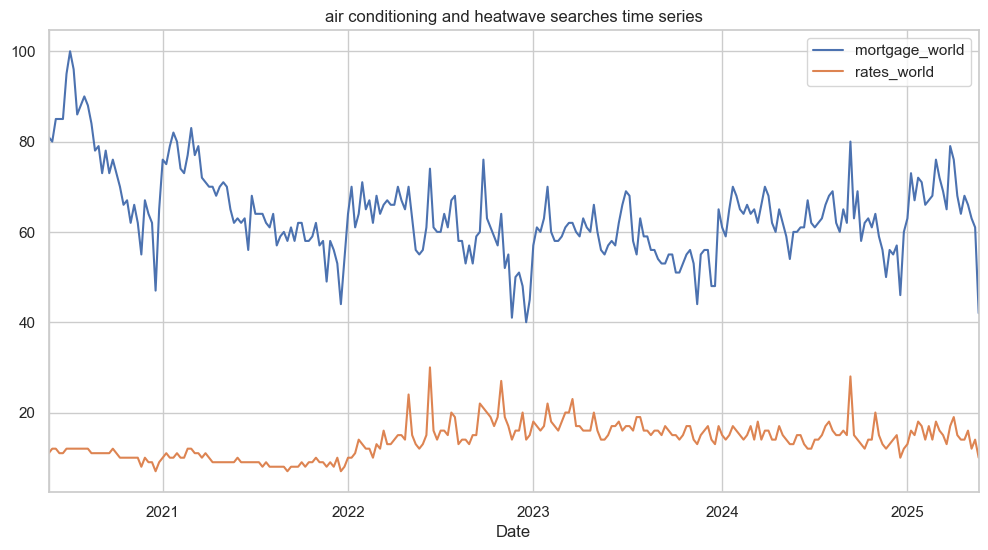

In [236]:
data[['mortgage_world', 'rates_world']].plot(figsize=(12, 6), title='air conditioning and heatwave searches time series')
plt.show()

As we see, our dataset consists of weekly Google Trends search data from 2020 to 2025 for keywords related to mortgages and interest rates across three regions: World, US, and Poland. We checked for missing values, ensured proper date indexing, and transformed the data to first differences where necessary to achieve stationarity. These steps prepared the data for time series modeling and forecasting.

***

## <a id="integration-order-and-granger-causality"></a>Integration order and Granger causality

In this section, we determine the stationarity of the time series by identifying their integration order using tests like the Augmented Dickey-Fuller (ADF) test. Stationarity is a prerequisite for Granger causality analysis, which examines whether one time series can predict another. The results help establish the causal relationship between the variables, providing insights into their dynamic interactions.

In [237]:
def adf_test(series, max_aug=10, version='c'):

    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations

        for aug in range(1, i+1): # adding augmentations max_aug is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            if nobs > 100:
                cv01 = -2.567; cv05 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 'c': # critical values for version with constant
            if nobs > 100:
                cv01 = -3.434; cv05 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 't': # critical values for version with constant and (deterministic) trend component
            if nobs > 100:
                cv01 = -3.963; cv05 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

        bg_test01 = smd.acorr_breusch_godfrey(model, nlags=1);  bg_pvalue01 = round(bg_test01[1],4); bg_test01 = round(bg_test01[0],4);
        bg_test05 = smd.acorr_breusch_godfrey(model, nlags=5);  bg_pvalue05 = round(bg_test05[1],4); bg_test05 = round(bg_test05[0],4);
        bg_test10 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test10[1],4); bg_test10 = round(bg_test10[0],4);
        bg_test15 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test15[1],4); bg_test15 = round(bg_test15[0],4);

        results.append([i, ts, cv01, cv05, cv10,
                        bg_test01, bg_pvalue01, bg_test05, bg_pvalue05, bg_test10, bg_pvalue10, bg_test15, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations',
                          'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)',
                          'BG test (1 lag) (statistic)', 'BG test (1 lag) (p-value)',
                          'BG test (5 lags) (statistic)', 'BG test (5 lags) (p-value)',
                          'BG test (10 lags) (statistic)', 'BG test (10 lags) (p-value)',
                          'BG test (15 lags) (statistic)', 'BG test (15 lags) (p-value)']

    return results_df

In [238]:
adf_test(data['mortgage_world'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-5.0798755533,-3.4340000000,-2.8630000000,-2.5680000000,9.0250000000,0.0027000000,28.6168000000,0.0000000000,40.2341000000,0.0000000000,54.3936000000,0.0000000000
1,1,-4.0621764783,-3.4340000000,-2.8630000000,-2.5680000000,0.8438000000,0.3583000000,20.8780000000,0.0009000000,31.0291000000,0.0006000000,46.4080000000,0.0000000000
2,2,-3.9262688208,-3.4340000000,-2.8630000000,-2.5680000000,6.4410000000,0.0112000000,19.0163000000,0.0019000000,31.0283000000,0.0006000000,46.8120000000,0.0000000000
3,3,-3.2052000726,-3.4340000000,-2.8630000000,-2.5680000000,1.3516000000,0.2450000000,11.4542000000,0.0431000000,26.0777000000,0.0036000000,34.4241000000,0.0030000000
4,4,-3.4185665204,-3.4340000000,-2.8630000000,-2.5680000000,9.1292000000,0.0025000000,18.0741000000,0.0029000000,24.5150000000,0.0063000000,36.0959000000,0.0017000000
5,5,-4.1412270465,-3.4340000000,-2.8630000000,-2.5680000000,1.3799000000,0.2401000000,7.4764000000,0.1876000000,12.8519000000,0.2321000000,26.2284000000,0.0357000000
6,6,-4.2444444814,-3.4340000000,-2.8630000000,-2.5680000000,0.0262000000,0.8715000000,4.9219000000,0.4255000000,21.4692000000,0.0180000000,22.8668000000,0.0870000000
7,7,-4.4151304844,-3.4340000000,-2.8630000000,-2.5680000000,0.2768000000,0.5988000000,7.4592000000,0.1887000000,19.8674000000,0.0305000000,20.5111000000,0.1532000000
8,8,-4.0974596273,-3.4340000000,-2.8630000000,-2.5680000000,3.0051000000,0.0830000000,8.6940000000,0.1219000000,18.0422000000,0.0543000000,19.1878000000,0.2053000000
9,9,-4.3593161273,-3.4340000000,-2.8630000000,-2.5680000000,0.5914000000,0.4419000000,10.4080000000,0.0645000000,14.8680000000,0.1369000000,19.4022000000,0.1961000000


The ADF statistic results indicate that we can reject the null hypothesis about the non-stationarity for all of the analyzed models. However, the results of the BG test, regarding the autocorrelation, show the presence of the autocorrelation of the residuals for lags up to 15 lags for models with up to 4 augmentations. The model with 5 augmentations is stationary and has no problem with autocorrelation. Let's check the stationarity of the differenciated series *d_mortgage_world*.

In [239]:
adf_test(data['d_mortgage_world'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-20.5276751222,-3.4340000000,-2.8630000000,-2.5680000000,2.5222000000,0.1123000000,24.8187000000,0.0002000000,34.4372000000,0.0002000000,48.0486000000,0.0000000000
1,1,-13.7459853479,-3.4340000000,-2.8630000000,-2.5680000000,16.7534000000,0.0000000000,21.4158000000,0.0007000000,33.2925000000,0.0002000000,46.6335000000,0.0000000000
2,2,-13.7466705534,-3.4340000000,-2.8630000000,-2.5680000000,0.6518000000,0.4195000000,8.4096000000,0.1351000000,18.6327000000,0.0452000000,32.1436000000,0.0062000000
3,3,-9.6278187228,-3.4340000000,-2.8630000000,-2.5680000000,3.0328000000,0.0816000000,12.8111000000,0.0252000000,25.1910000000,0.0050000000,32.8279000000,0.0050000000
4,4,-7.5728512350,-3.4340000000,-2.8630000000,-2.5680000000,0.0558000000,0.8132000000,3.7315000000,0.5887000000,10.7083000000,0.3807000000,23.7591000000,0.0693000000
5,5,-7.8974732694,-3.4340000000,-2.8630000000,-2.5680000000,0.1852000000,0.6669000000,6.0794000000,0.2986000000,20.6266000000,0.0239000000,21.2692000000,0.1284000000
6,6,-6.6897197746,-3.4340000000,-2.8630000000,-2.5680000000,0.1750000000,0.6757000000,8.0687000000,0.1525000000,24.2040000000,0.0071000000,26.1715000000,0.0363000000
7,7,-6.3342574154,-3.4340000000,-2.8630000000,-2.5680000000,0.2172000000,0.6411000000,8.5080000000,0.1304000000,15.1805000000,0.1256000000,17.5675000000,0.2861000000
8,8,-5.4380967143,-3.4340000000,-2.8630000000,-2.5680000000,3.8686000000,0.0492000000,11.1979000000,0.0476000000,19.6028000000,0.0332000000,22.9923000000,0.0843000000
9,9,-5.7883936210,-3.4340000000,-2.8630000000,-2.5680000000,0.0723000000,0.7879000000,14.4917000000,0.0128000000,19.3083000000,0.0365000000,19.8046000000,0.1796000000


Based on the results, we can see that the differentiated series *d_mortgage_world* is stationary and has no problems with autocorrelation for a model with 4 augmentations. Hence, the series *mortgage_world* is **integrated of order 1**. Now let's check the series *rates_world*.

In [240]:
adf_test(data['rates_world'], max_aug=10)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.3648905215,-3.4340000000,-2.8630000000,-2.5680000000,17.5037000000,0.0000000000,59.7233000000,0.0000000000,68.4010000000,0.0000000000,79.3090000000,0.0000000000
1,1,-4.5193851780,-3.4340000000,-2.8630000000,-2.5680000000,7.0792000000,0.0078000000,50.1388000000,0.0000000000,55.0106000000,0.0000000000,67.1095000000,0.0000000000
2,2,-3.6677302587,-3.4340000000,-2.8630000000,-2.5680000000,12.7423000000,0.0004000000,44.5298000000,0.0000000000,49.4944000000,0.0000000000,61.8447000000,0.0000000000
3,3,-2.8718245249,-3.4340000000,-2.8630000000,-2.5680000000,10.6749000000,0.0011000000,34.5632000000,0.0000000000,40.5234000000,0.0000000000,50.9852000000,0.0000000000
4,4,-2.3178563107,-3.4340000000,-2.8630000000,-2.5680000000,22.7119000000,0.0000000000,27.4785000000,0.0000000000,39.0219000000,0.0000000000,44.0568000000,0.0001000000
5,5,-1.7027941042,-3.4340000000,-2.8630000000,-2.5680000000,0.3846000000,0.5352000000,5.6169000000,0.3453000000,21.1635000000,0.0200000000,26.0084000000,0.0379000000
6,6,-1.6233546529,-3.4340000000,-2.8630000000,-2.5680000000,2.0379000000,0.1534000000,5.2084000000,0.3910000000,20.5690000000,0.0243000000,26.4987000000,0.0331000000
7,7,-1.7485483338,-3.4340000000,-2.8630000000,-2.5680000000,0.5160000000,0.4726000000,13.9881000000,0.0157000000,20.0546000000,0.0287000000,31.1296000000,0.0084000000
8,8,-1.6610009609,-3.4340000000,-2.8630000000,-2.5680000000,2.4865000000,0.1148000000,13.6001000000,0.0184000000,20.0782000000,0.0285000000,37.9080000000,0.0009000000
9,9,-1.7977767124,-3.4340000000,-2.8630000000,-2.5680000000,0.2127000000,0.6447000000,16.1542000000,0.0064000000,20.2226000000,0.0272000000,37.5735000000,0.0010000000


The results of the ADF test indicate that the series is stationary for the model with up to 3 augmentations (assuming the 5% significance level). However, the results of the BG test show that there is a serious autocorrelation of the residuals. Hence, we need to analyze the differentiated series *d_rates_world*.

In [211]:
adf_test(data['d_rates_world'], max_aug=10)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-23.3265777949,-3.4340000000,-2.8630000000,-2.5680000000,13.3437000000,0.0003000000,63.4038000000,0.0000000000,67.5941000000,0.0000000000,80.4902000000,0.0000000000
1,1,-16.5853368096,-3.4340000000,-2.8630000000,-2.5680000000,17.4084000000,0.0000000000,53.8753000000,0.0000000000,57.9831000000,0.0000000000,70.5249000000,0.0000000000
2,2,-14.9230703897,-3.4340000000,-2.8630000000,-2.5680000000,13.3623000000,0.0003000000,39.4801000000,0.0000000000,46.1325000000,0.0000000000,55.8988000000,0.0000000000
3,3,-13.6550088171,-3.4340000000,-2.8630000000,-2.5680000000,25.0435000000,0.0000000000,29.4408000000,0.0000000000,42.9816000000,0.0000000000,47.3853000000,0.0000000000
4,4,-14.2372929929,-3.4340000000,-2.8630000000,-2.5680000000,0.6192000000,0.4313000000,4.9727000000,0.4192000000,22.1225000000,0.0145000000,27.1896000000,0.0272000000
5,5,-11.0156675970,-3.4340000000,-2.8630000000,-2.5680000000,1.5150000000,0.2184000000,4.4724000000,0.4836000000,21.2745000000,0.0193000000,27.4682000000,0.0251000000
6,6,-8.1613803280,-3.4340000000,-2.8630000000,-2.5680000000,0.7897000000,0.3742000000,4.7994000000,0.4409000000,20.8012000000,0.0225000000,30.4185000000,0.0105000000
7,7,-7.5545162496,-3.4340000000,-2.8630000000,-2.5680000000,1.9115000000,0.1668000000,14.4223000000,0.0131000000,21.1052000000,0.0204000000,37.3507000000,0.0011000000
8,8,-6.1540201961,-3.4340000000,-2.8630000000,-2.5680000000,0.0740000000,0.7855000000,17.2567000000,0.0040000000,19.4049000000,0.0354000000,38.7745000000,0.0007000000
9,9,-5.5780268323,-3.4340000000,-2.8630000000,-2.5680000000,1.3525000000,0.2448000000,17.3666000000,0.0039000000,23.6205000000,0.0087000000,39.2532000000,0.0006000000


The differenciated series shows the stationarity for all of the augmentations. However, there is still a problem with autocorrelation of the residuals - the model with 4 augmentations is characterized with no autocorrelation up to 5 lags (up to 15 with 1% significance level). Hence, the series *rates_world* is **integrated of order 1**.


In this subsection, we perform **Granger causality** tests to determine whether one time series can predict another. The test evaluates the null hypothesis that the lagged values of one series do not provide statistically significant information about the future values of another series. By analyzing the p-values for different lags, we identify the presence and direction of causality between the variables, offering insights into their dynamic relationships.

In [247]:
grangercausalitytests(data[['mortgage_world', 'rates_world']].dropna(), maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.0589 , p=0.0001  , df_denom=258, df_num=1
ssr based chi2 test:   chi2=16.2456 , p=0.0001  , df=1
likelihood ratio test: chi2=15.7601 , p=0.0001  , df=1
parameter F test:         F=16.0589 , p=0.0001  , df_denom=258, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.9259  , p=0.0031  , df_denom=255, df_num=2
ssr based chi2 test:   chi2=12.0842 , p=0.0024  , df=2
likelihood ratio test: chi2=11.8118 , p=0.0027  , df=2
parameter F test:         F=5.9259  , p=0.0031  , df_denom=255, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7136  , p=0.0121  , df_denom=252, df_num=3
ssr based chi2 test:   chi2=11.4501 , p=0.0095  , df=3
likelihood ratio test: chi2=11.2043 , p=0.0107  , df=3
parameter F test:         F=3.7136  , p=0.0121  , df_denom=252, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5214  , p=0.0417  

{np.int64(1): ({'ssr_ftest': (np.float64(16.058867922720996),
    np.float64(8.039873144363321e-05),
    np.float64(258.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(16.245598945078218),
    np.float64(5.563868812212872e-05),
    np.int64(1)),
   'lrtest': (np.float64(15.760052998947003),
    np.float64(7.190481768364763e-05),
    np.int64(1)),
   'params_ftest': (np.float64(16.058867922721184),
    np.float64(8.039873144362547e-05),
    np.float64(258.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(5.9259128885065975),
    np.float64(0.0030508807985175647),
    np.float64(255.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(12.084214517738944),
    np.float64(0.002376545636464492),
    np.int64(2)),
   'lrtest': (np.float64(11.811799885099163),
    np.float64(0.0027233298371985497),
    np.int64(2)),
   'params_ftest': (np.float64(5.925912888506541),
    np.float64(0.0030508807985177456),
    np.float64(255.0),
    2.0)},
   array([[0., 0

We reject the null hypothesis of no causalty at the 5% significance level for lags 1, 2, 3, 4, and 5. This means that ***rates*** Granger causes ***mortgage*** at the 5% significance level. Hence, we can conclude that ***rates*** is a Granger cause of  ***mortgage***.

In [248]:
grangercausalitytests(data[['rates_world', 'mortgage_world']].dropna(), maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3008 , p=0.0015  , df_denom=258, df_num=1
ssr based chi2 test:   chi2=10.4205 , p=0.0012  , df=1
likelihood ratio test: chi2=10.2179 , p=0.0014  , df=1
parameter F test:         F=10.3008 , p=0.0015  , df_denom=258, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5150  , p=0.0118  , df_denom=255, df_num=2
ssr based chi2 test:   chi2=9.2070  , p=0.0100  , df=2
likelihood ratio test: chi2=9.0477  , p=0.0108  , df=2
parameter F test:         F=4.5150  , p=0.0118  , df_denom=255, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9391  , p=0.0338  , df_denom=252, df_num=3
ssr based chi2 test:   chi2=9.0622  , p=0.0285  , df=3
likelihood ratio test: chi2=8.9073  , p=0.0305  , df=3
parameter F test:         F=2.9391  , p=0.0338  , df_denom=252, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7220  , p=0.1456  

{np.int64(1): ({'ssr_ftest': (np.float64(10.30076520388854),
    np.float64(0.0014980953180058266),
    np.float64(258.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(10.42054154346864),
    np.float64(0.001246213455219387),
    np.int64(1)),
   'lrtest': (np.float64(10.2178954079925),
    np.float64(0.0013908447127871121),
    np.int64(1)),
   'params_ftest': (np.float64(10.3007652038913),
    np.float64(0.0014980953180036972),
    np.float64(258.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(4.514976998394101),
    np.float64(0.011832867457575424),
    np.float64(255.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(9.207011918293853),
    np.float64(0.010016656124351951),
    np.int64(2)),
   'lrtest': (np.float64(9.047743551755502),
    np.float64(0.010846945320913093),
    np.int64(2)),
   'params_ftest': (np.float64(4.5149769983940695),
    np.float64(0.011832867457575773),
    np.float64(255.0),
    2.0)},
   array([[0., 0., 1., 0., 0

We reject the null hypothesis of no causalty at the 5% significance level for lags 1, 2, and 3. This means that ***mortgage*** Granger causes ***rates*** at the 5% significance level. Hence, we can conclude that ***mortgage*** is a Granger cause of  ***rates***.

***

## <a id="VAR-model"></a>VAR model

In this section, we specify, estimate, and evaluate a Vector Autoregression (VAR) model to analyze the dynamic relationship between the time series. The VAR model captures the interdependencies between the variables by modeling each as a function of its own lags and the lags of the other variables. We determine the optimal lag order using information criteria (AIC, BIC, HQIC, FPE) and assess the model's adequacy through diagnostic checks, including residual autocorrelation and stability tests. The model's performance is further evaluated using impulse response functions (IRF) and forecast error variance decomposition (FEVD) to interpret the interactions and forecast accuracy.

### <a id="VAR-model-specification"></a>VAR model specification

Since we know that the series *d_mortgage_world* and *dd_rates_world* are stationary we can create a VAR model.

In [249]:
data_train = data[['mortgage_world', 'rates_world']].dropna()
forecast_horizon = 6
data_train_short = data_train.iloc[:-forecast_horizon]

In [250]:
model = VAR(data_train, freq='W')
results = model.select_order(maxlags=15)
print("\nLag selection results:")
print(results.summary())


Lag selection results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        6.742       6.770       847.2       6.753
1        4.897       4.982       133.8       4.931
2        4.794       4.936       120.8       4.851
3        4.778       4.977       118.9       4.859
4        4.744       4.999       114.9       4.847
5        4.700       5.012       110.0       4.826
6        4.522      4.891*       92.00      4.670*
7        4.524       4.951       92.27       4.696
8        4.521       5.004       91.96       4.715
9        4.543       5.083       94.02       4.760
10       4.550       5.147       94.75       4.791
11       4.574       5.228       97.04       4.837
12       4.594       5.304       99.02       4.880
13       4.586       5.353       98.27       4.895
14       4.553       5.377       95.10       4.885
15      4.514*       5.395      91.56*       4.869
-------

Information criteria for different lag orders:
  aic bic hqic fpe
1   1   1    1   1
2   2   2    2   2
3   3   2    2   3
4   4   2    4   4
5   5   2    5   5
6   6   6    6   6


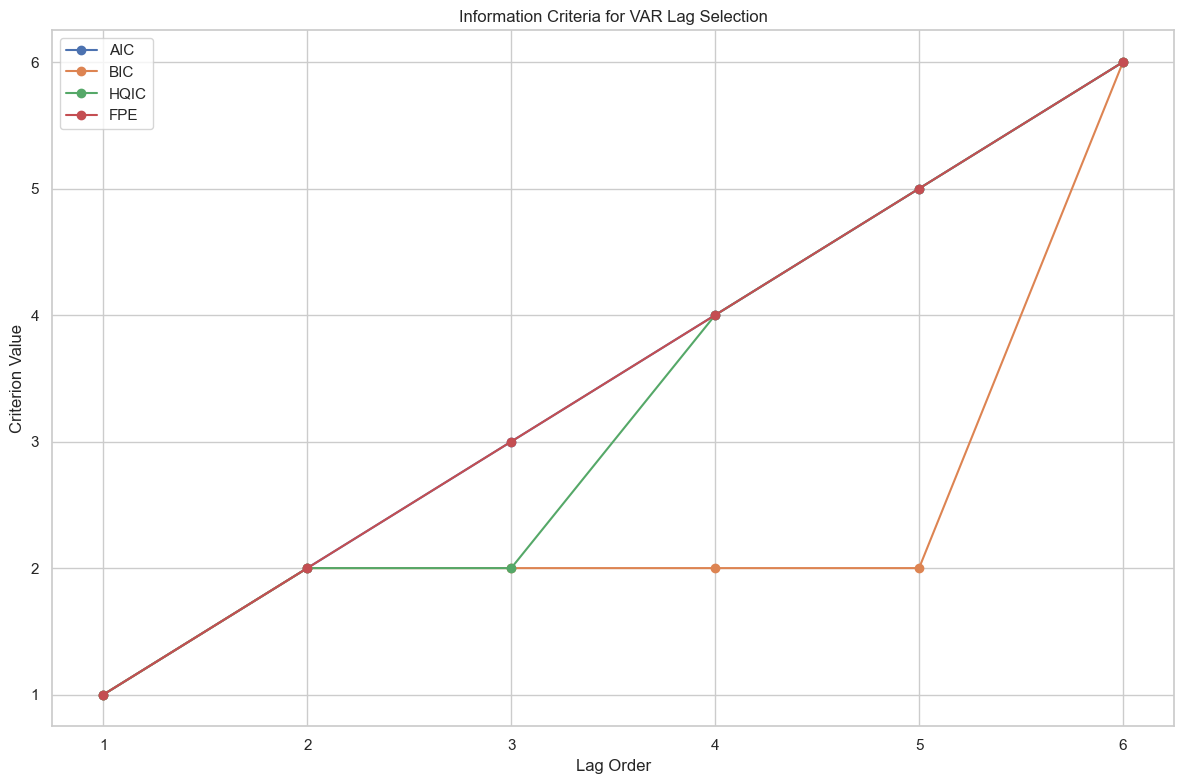

In [251]:
# Function to select optimal lag order
def select_var_order(data, max_lags=12):
    # Create a VAR model
    model = VAR(data, freq='W')

    # Determine information criteria for different lag orders
    results = {}
    for i in range(1, max_lags + 1):
        results[i] = model.select_order(i)

    # Create a DataFrame to display the results
    criteria = ['aic', 'bic', 'hqic', 'fpe']
    order_df = pd.DataFrame(index=range(1, max_lags + 1), columns=criteria)

    for i in range(1, max_lags + 1):
        for criterion in criteria:
            order_df.loc[i, criterion] = getattr(results[i], criterion)

    return order_df

# Select optimal lag order
lag_order_results = select_var_order(data_train, max_lags=6)
print("Information criteria for different lag orders:")
print(lag_order_results)

# Plot the information criteria
plt.figure(figsize=(12, 8))
for column in lag_order_results.columns:
    plt.plot(lag_order_results.index, lag_order_results[column], marker='o', label=column.upper())
plt.xlabel('Lag Order')
plt.ylabel('Criterion Value')
plt.title('Information Criteria for VAR Lag Selection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Based on the information criteria and the simplicity of the model we choose the model with 6 and 15 lags for further anlysis.

### <a id="VAR-model-estimation"></a>VAR model estimation

In [252]:
var6_model = VAR(data_train, freq='W')
var6_results = var6_model.fit(6)

print(var6_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Jul, 2025
Time:                     00:33:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.86129
Nobs:                     256.000    HQIC:                   4.64605
Log likelihood:          -1276.65    FPE:                    90.1443
AIC:                      4.50124    Det(Omega_mle):         81.6420
--------------------------------------------------------------------
Results for equation mortgage_world
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    14.890415         3.275528            4.546           0.000
L1.mortgage_world         0.666945         0.078317            8.516           0.000
L1.rates_world           -0.272961 

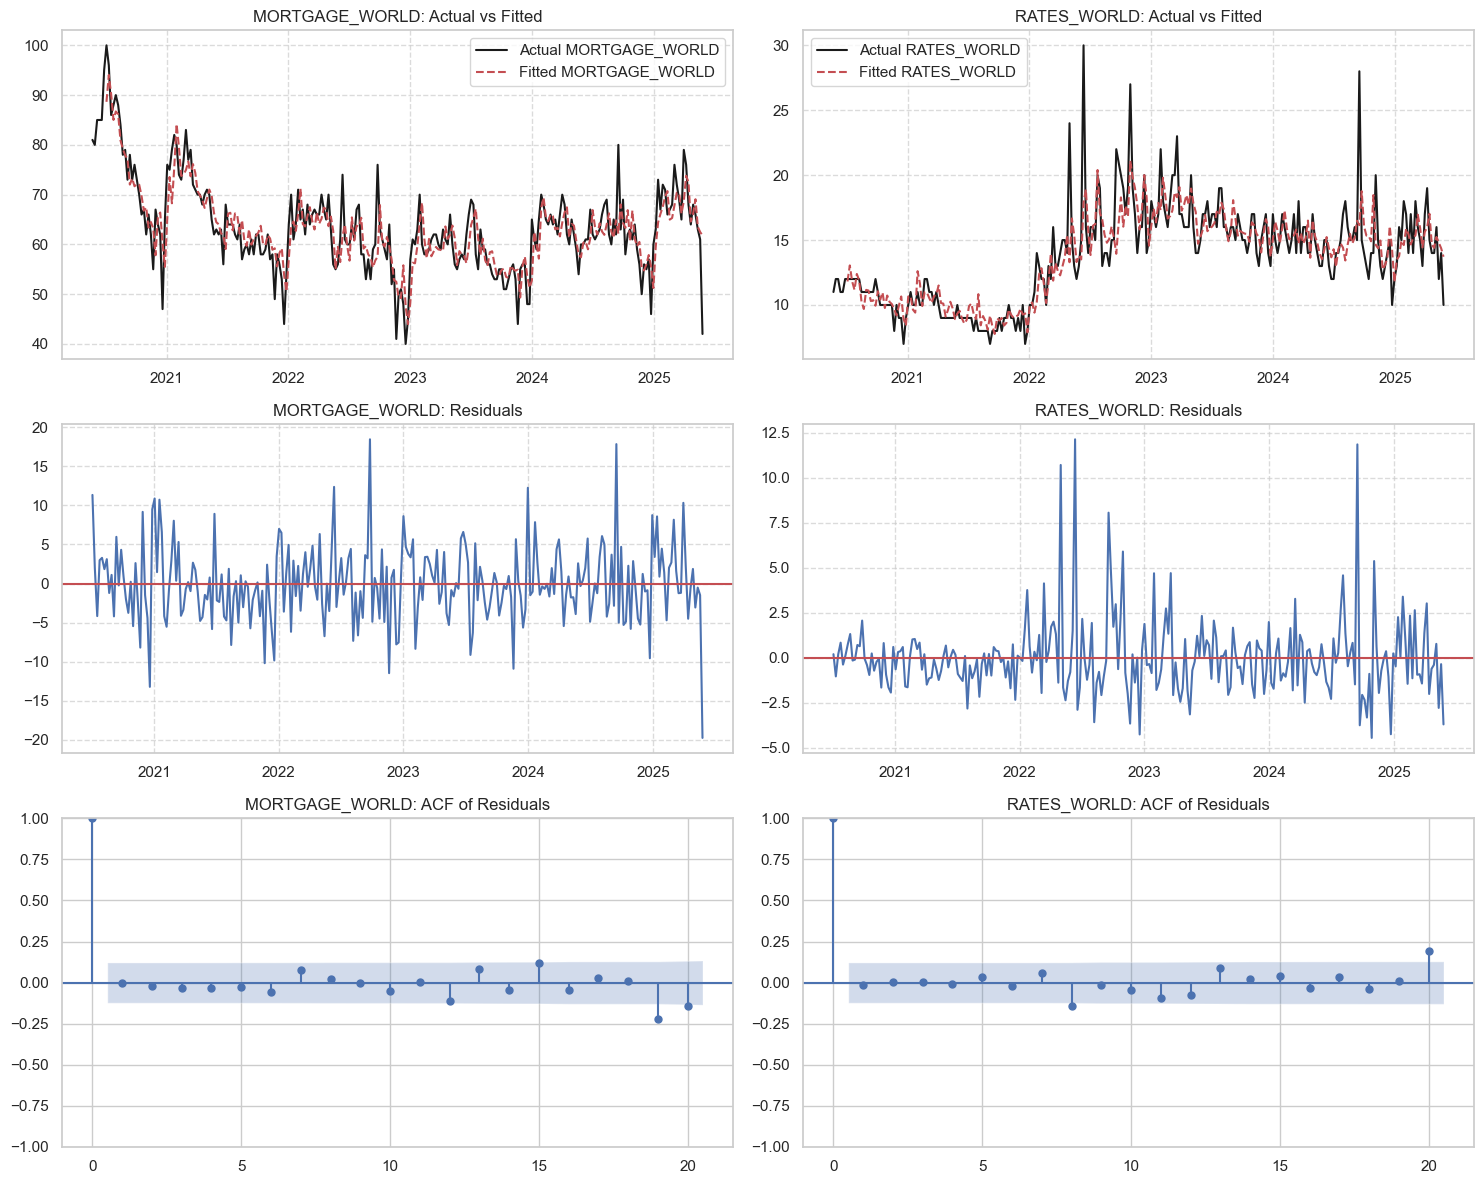

In [253]:
# Plot fitted values vs actual values, residuals, and ACF/PACF
fig = plt.figure(figsize=(15, 12))

# Fitted values vs actual values for each variable
for i, name in enumerate(data_train.columns):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(data_train.index, data_train[name], 'k-', label=f'Actual {name.upper()}')
    ax.plot(var6_results.fittedvalues[name].index, var6_results.fittedvalues[name], 'r--',
            label=f'Fitted {name.upper()}')
    ax.set_title(f'{name.upper()}: Actual vs Fitted')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Residuals for each variable
for i, name in enumerate(data_train.columns):
    ax = fig.add_subplot(3, 2, i+3)
    residuals = var6_results.resid[name]
    ax.plot(residuals.index, residuals, 'b-')
    ax.axhline(y=0, color='r', linestyle='-')
    ax.set_title(f'{name.upper()}: Residuals')
    ax.grid(True, linestyle='--', alpha=0.7)

# ACF and PACF for residuals
for i, name in enumerate(data_train.columns):
    ax = fig.add_subplot(3, 2, i+5)
    residuals = var6_results.resid[name].values
    plot_acf(residuals, ax=ax, lags=20, alpha=0.05, title=f'{name.upper()}: ACF of Residuals')

plt.tight_layout()
plt.show()


In [254]:
# Perform Ljung-Box test for autocorrelation of residuals (equivalent to Portmanteau test)
residuals = var6_results.resid

print("Ljung-Box Test for Residual Autocorrelation:")
for name in residuals.columns:
    lb_test = acorr_ljungbox(residuals[name], lags=[12, 24])
    print(f"\n{name.upper()} series:")
    print(f"Lag 12: p-value = {lb_test.iloc[0, 1]:.4f}")
    print(f"Lag 24: p-value = {lb_test.iloc[1, 1]:.4f}")

Ljung-Box Test for Residual Autocorrelation:

MORTGAGE_WORLD series:
Lag 12: p-value = 0.8358
Lag 24: p-value = 0.0226

RATES_WORLD series:
Lag 12: p-value = 0.5222
Lag 24: p-value = 0.2903


The VAR(6) is performing well - there is no problem with residual autocorrelation. Let's see the model with 15 lags.

In [255]:
var15_model = VAR(data_train, freq='W')
var15_results = var15_model.fit(14)

print(var15_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Jul, 2025
Time:                     00:34:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    5.36568
Nobs:                     248.000    HQIC:                   4.87477
Log likelihood:          -1209.25    FPE:                    94.2676
AIC:                      4.54399    Det(Omega_mle):         75.5625
--------------------------------------------------------------------
Results for equation mortgage_world
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     18.341644         4.447525            4.124           0.000
L1.mortgage_world          0.666998         0.084118            7.929           0.000
L1.rates_world            -0.12

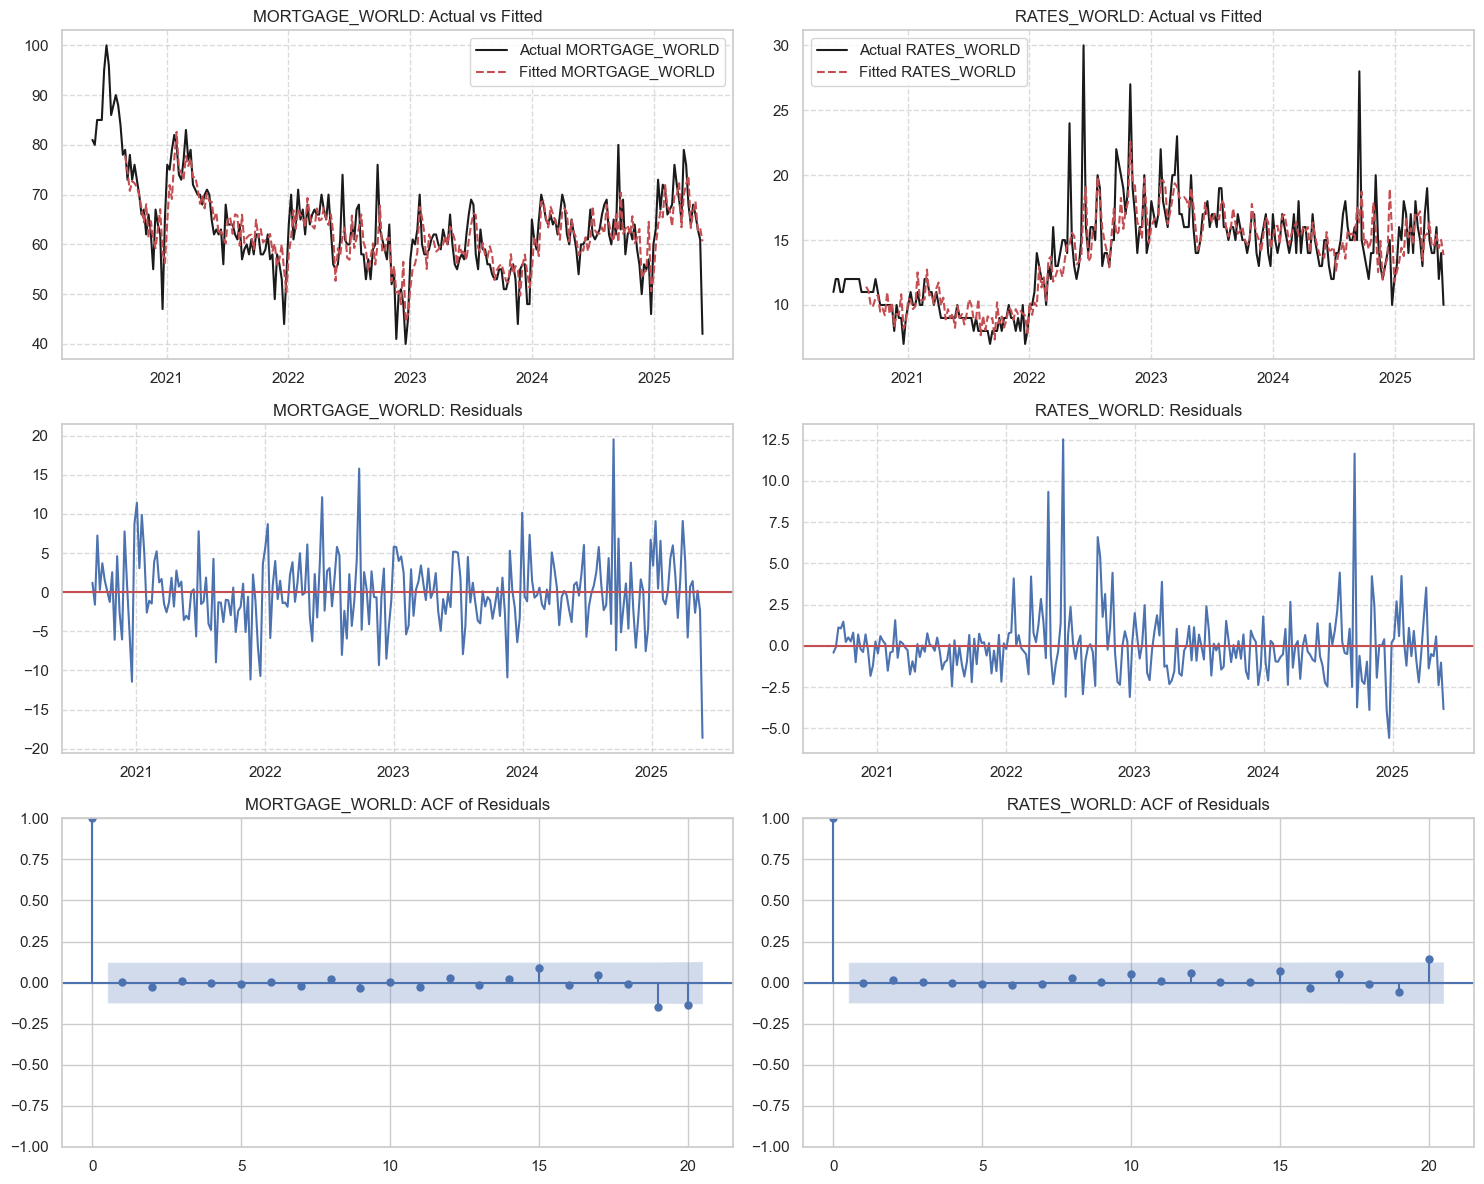

In [256]:
fig = plt.figure(figsize=(15, 12))

# Fitted values vs actual values for each variable
for i, name in enumerate(data_train.columns):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(data_train.index, data_train[name], 'k-', label=f'Actual {name.upper()}')
    ax.plot(var15_results.fittedvalues[name].index, var15_results.fittedvalues[name], 'r--',
            label=f'Fitted {name.upper()}')
    ax.set_title(f'{name.upper()}: Actual vs Fitted')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Residuals for each variable
for i, name in enumerate(data_train.columns):
    ax = fig.add_subplot(3, 2, i+3)
    residuals = var15_results.resid[name]
    ax.plot(residuals.index, residuals, 'b-')
    ax.axhline(y=0, color='r', linestyle='-')
    ax.set_title(f'{name.upper()}: Residuals')
    ax.grid(True, linestyle='--', alpha=0.7)

# ACF and PACF for residuals
for i, name in enumerate(data_train.columns):
    ax = fig.add_subplot(3, 2, i+5)
    residuals = var15_results.resid[name].values
    plot_acf(residuals, ax=ax, lags=20, alpha=0.05, title=f'{name.upper()}: ACF of Residuals')

plt.tight_layout()
plt.show()


In [257]:
residuals = var15_results.resid

print("Ljung-Box Test for Residual Autocorrelation:")
for name in residuals.columns:
    lb_test = acorr_ljungbox(residuals[name], lags=[12, 24])
    print(f"\n{name.upper()} series:")
    print(f"Lag 12: p-value = {lb_test.iloc[0, 1]:.4f}")
    print(f"Lag 24: p-value = {lb_test.iloc[1, 1]:.4f}")

Ljung-Box Test for Residual Autocorrelation:

MORTGAGE_WORLD series:
Lag 12: p-value = 1.0000
Lag 24: p-value = 0.7878

RATES_WORLD series:
Lag 12: p-value = 0.9995
Lag 24: p-value = 0.9639


Similar to the VAR(6) model - no residual autocorrelation was detected. Let's compare the two models and decide with which we will proceed our analysis and forecast.

In [258]:
# Compare information criteria for the two models
ic_comparison = pd.DataFrame({
    'VAR(6)': [var6_results.aic, var6_results.bic, var6_results.hqic, var6_results.fpe],
    'VAR(15)': [var15_results.aic, var15_results.bic, var15_results.hqic, var15_results.fpe]
}, index=['AIC', 'BIC', 'HQIC', 'FPE'])

print("Information Criteria Comparison:")
print(ic_comparison)

# Find the best model according to each criterion (smaller is better)
best_model = ic_comparison.idxmin(axis=1)
print("\nBest model according to each criterion:")
print(best_model)

Information Criteria Comparison:
            VAR(6)       VAR(15)
AIC   4.5012365398  4.5439877883
BIC   4.8612936241  5.3656767692
HQIC  4.6460501660  4.8747686672
FPE  90.1442722964 94.2675867297

Best model according to each criterion:
AIC     VAR(6)
BIC     VAR(6)
HQIC    VAR(6)
FPE     VAR(6)
dtype: object


VAR(6) was selected based on all four information criteria (AIC, BIC, HQIC, FPE). Let's perform the diagnosis of the VAR(6) model.

### <a id="VAR-model-diagnostics"></a>VAR model diagnostics

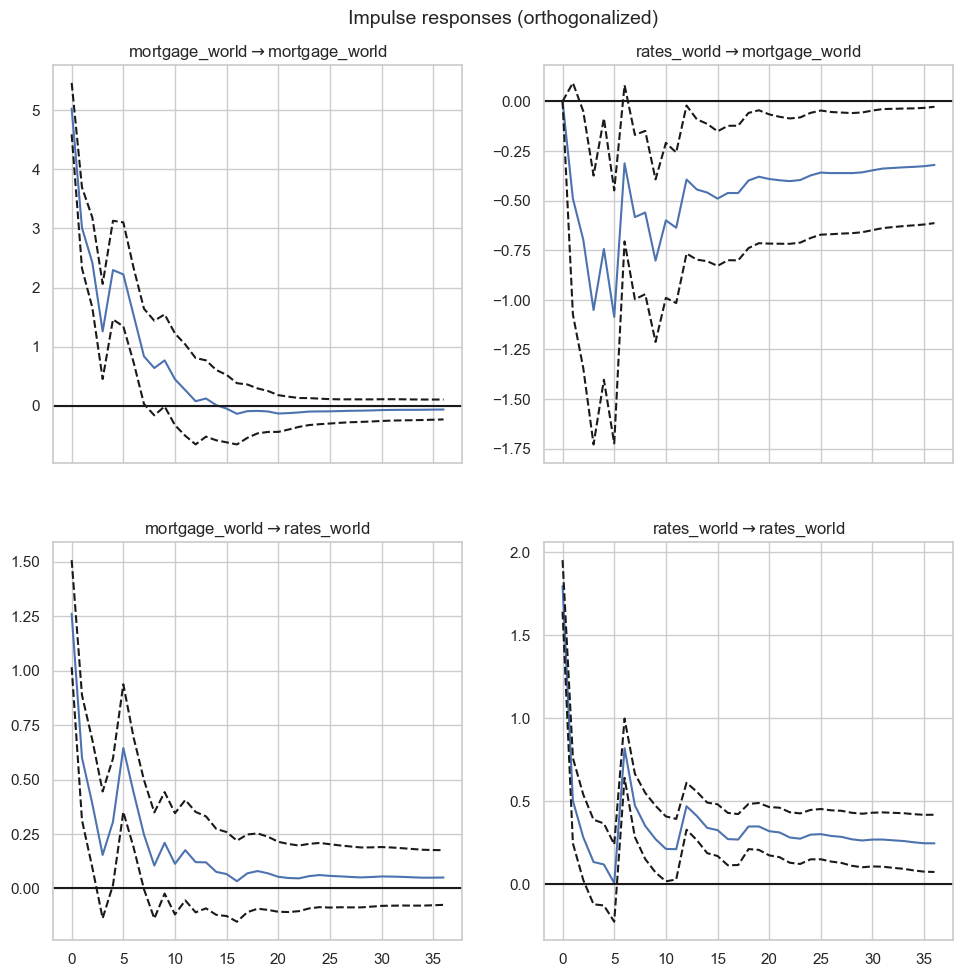

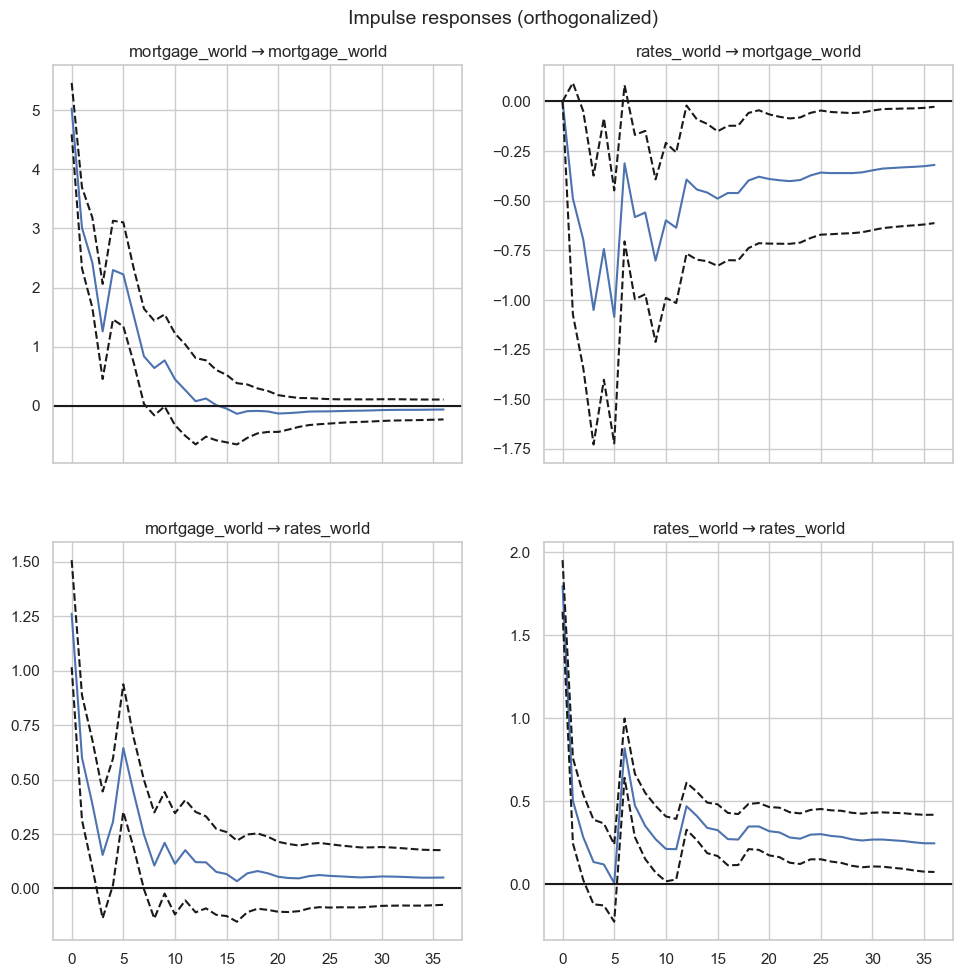

In [259]:
# Calculate and plot impulse response functions
irf = var6_results.irf(36)  # 36 periods ahead (equivalent to n.ahead=36 in R)

# Orthogonalization is done using the Cholesky decomposition of the estimated error covariance matrix
# and hence interpretations may change depending on variable ordering.
irf.plot(orth=True)

The IRF plots reveal that a shock to `rates_world` leads to an significant positive and then negative impact on `mortgage_world` - later it will oscillate around 0. A shock to `mortgage_world` has a similar and more negative effect on `rates_world`, indicating asymmetry influence between these two variables.

FEVD for mortgage_world
      mortgage_world  rates_world
0           1.000000     0.000000
1           0.993042     0.006958
2           0.982282     0.017718
3           0.958042     0.041958
4           0.951786     0.048214
5           0.935880     0.064120
6           0.936895     0.063105
7           0.932243     0.067757
8           0.927807     0.072193
9           0.918708     0.081292
10          0.913603     0.086397
11          0.907725     0.092275
12          0.905468     0.094532
13          0.902627     0.097373
14          0.899584     0.100416
15          0.896149     0.103851
16          0.893150     0.106850
17          0.890154     0.109846
18          0.887936     0.112064
19          0.885938     0.114062
20          0.883845     0.116155
21          0.881689     0.118311
22          0.879491     0.120509
23          0.877359     0.122641
24          0.875479     0.124521
25          0.873750     0.126250
26          0.872001     0.127999
27          0.870260    

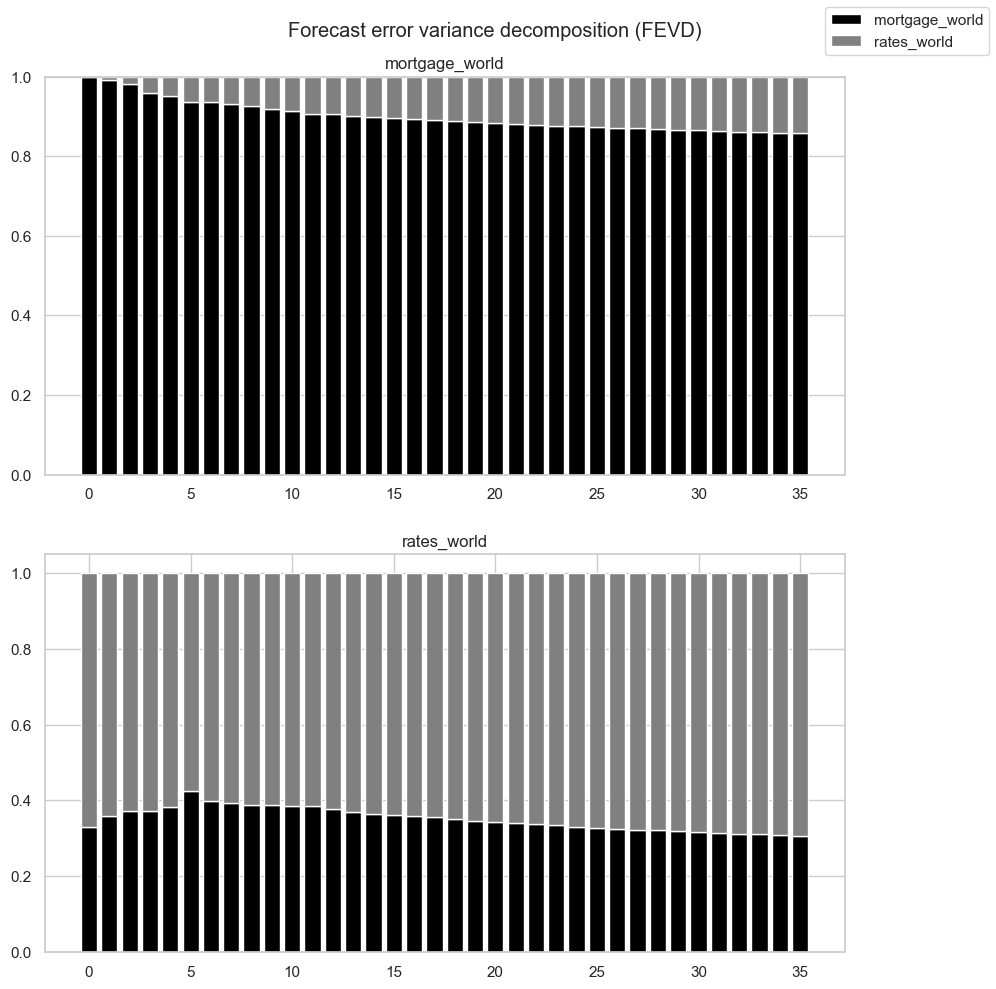

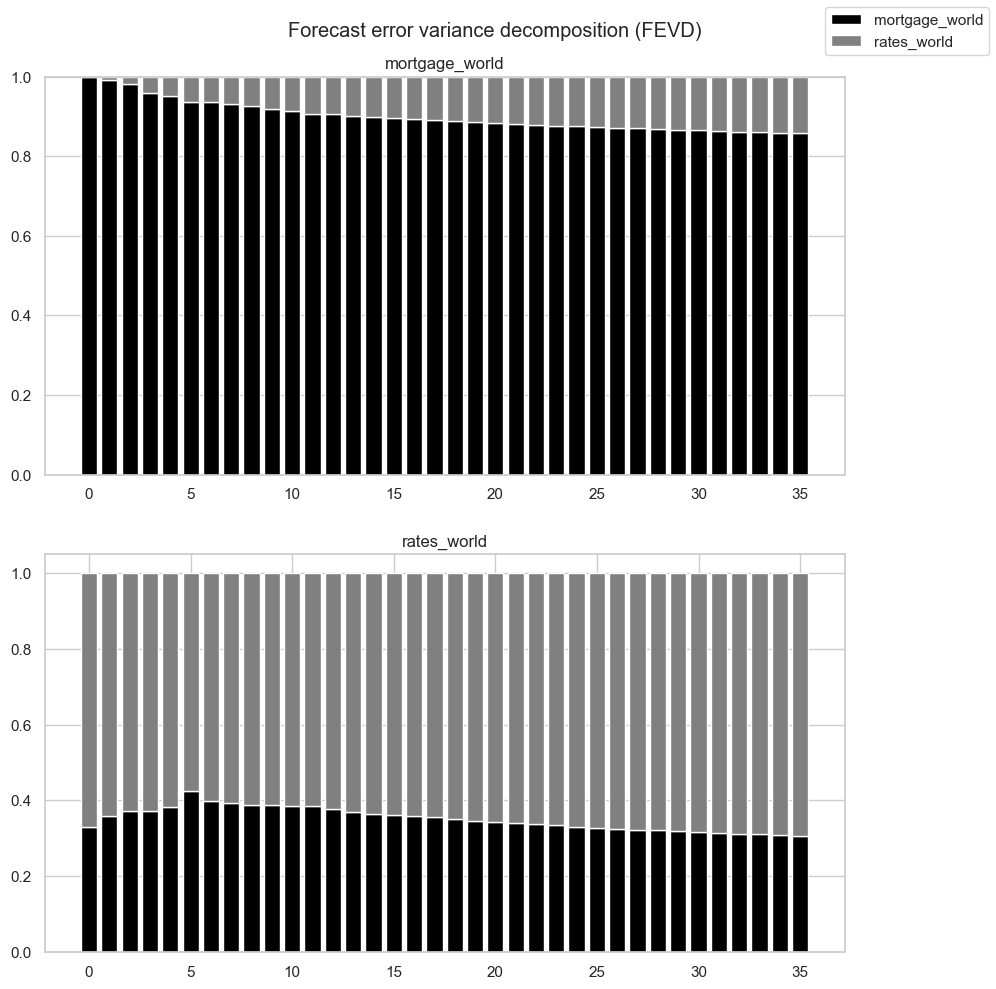

In [262]:
# Calculate and plot forecast error variance decomposition
fevd = var6_results.fevd(36)  # 36 periods ahead
fevd.summary()

# Plot FEVD
var6_results.fevd(36).plot()

The FEVD shows that most of the forecast variance in `mortgage_world` is explained by its own shocks, but around 30–40% is attributed to `rates_world` after several weeks. This confirms that interest rates play a huge role in driving mortgage-related search results over time.

### <a id="VAR-model-forecasting"></a>VAR model forecasting

In this subsection, we use the fitted VAR model to generate forecasts for the time series. The forecasts are evaluated against the actual values to assess the model's predictive accuracy. We also visualize the forecasted values alongside the observed data to analyze the model's performance. Metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) are computed to quantify the forecast accuracy.

In [263]:
forecast_horizon = 6
print("Original data shape:", data_train.shape)
print("Training data shape:", data_train_short.shape)
print("Last date in training data:", data_train_short.index[-1].strftime('%d-%m-%Y'))

# Fit VAR(6) model on the shorter sample
var6_short_model = VAR(data_train_short, freq='W')
var6_short_results = var6_short_model.fit(6)

# Generate forecasts
forecast = var6_short_results.forecast(data_train_short.values, steps=forecast_horizon)
forecast_index = pd.date_range(start=data_train_short.index[-1] + pd.DateOffset(weeks=1), periods=forecast_horizon, freq='W')

# Create a DataFrame for the forecasts
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=data_train.columns)

print("\nForecast results:")
print(forecast_df)

Original data shape: (262, 2)
Training data shape: (256, 2)
Last date in training data: 13-04-2025

Forecast results:
            mortgage_world   rates_world
2025-04-20   64.5946039148 14.6956089669
2025-04-27   66.7280993601 14.7187415587
2025-05-04   68.0843400678 15.3937461219
2025-05-11   64.8330429773 14.9372652756
2025-05-18   63.6464283539 15.4011333684
2025-05-25   62.8427462527 14.5091341617


In [264]:
def compute_forecast_ci(model_results, y_values, steps, alpha=0.05):
    """Compute confidence intervals for VAR forecasts"""
    forecast_mean = model_results.forecast(y_values, steps)

    # Get forecast error covariance matrix for h-step ahead forecasts
    mse = np.zeros((steps, model_results.neqs, model_results.neqs))
    for i in range(steps):
        mse[i] = model_results.forecast_cov(i+1)[0, :, :]

    # Compute standard errors for each forecast
    stderr = np.zeros((steps, model_results.neqs))
    for i in range(steps):
        stderr[i] = np.sqrt(np.diag(mse[i]))

    # Compute confidence intervals
    from scipy.stats import norm
    q = norm.ppf(1 - alpha/2)
    lower = forecast_mean - q * stderr
    upper = forecast_mean + q * stderr

    return forecast_mean, lower, upper

# Calculate forecast means and 95% confidence intervals
forecast_mean, forecast_lower, forecast_upper = compute_forecast_ci(
    var6_short_results, data_train_short.values, forecast_horizon, alpha=0.05
)

# Create DataFrames for the confidence intervals
forecast_lower_df = pd.DataFrame(forecast_lower, index=forecast_index,
                               columns=[f"{col}_lower" for col in data_train.columns])
forecast_upper_df = pd.DataFrame(forecast_upper, index=forecast_index,
                               columns=[f"{col}_upper" for col in data_train.columns])

# Combine the forecasts and actual values
forecast_evaluation = pd.concat([
    data_train.loc[forecast_index],
    forecast_df,
    forecast_lower_df,
    forecast_upper_df
], axis=1)

forecast_evaluation.columns = [
    'mortgage_actual', 'rates_actual',
    'mortgage_forecast', 'rates_forecast',
    'mortgage_lower', 'rates_lower',
    'mortgage_upper', 'rates_upper'
]

print("Forecast evaluation dataset:")
print(forecast_evaluation)


Forecast evaluation dataset:
            mortgage_actual  rates_actual  mortgage_forecast  rates_forecast  \
2025-04-20               64            14      64.5946039148   14.6956089669   
2025-04-27               68            14      66.7280993601   14.7187415587   
2025-05-04               66            16      68.0843400678   15.3937461219   
2025-05-11               63            12      64.8330429773   14.9372652756   
2025-05-18               61            14      63.6464283539   15.4011333684   
2025-05-25               42            10      62.8427462527   14.5091341617   

            mortgage_lower   rates_lower  mortgage_upper   rates_upper  
2025-04-20   54.9579435623 10.3830721922   74.2312642674 19.0081457417  
2025-04-27   57.0914390075 10.4062047840   76.3647597127 19.0312783334  
2025-05-04   58.4476797153 11.0812093472   77.7210004204 19.7062828966  
2025-05-11   55.1963826247 10.6247285009   74.4697033299 19.2498020503  
2025-05-18   54.0097680014 11.0885965937   73

The 6-week ahead forecasts show relatively small deviations from the actual values, particularly for mortgage searches. This suggests the VAR(6) model captures short-term dynamics well.

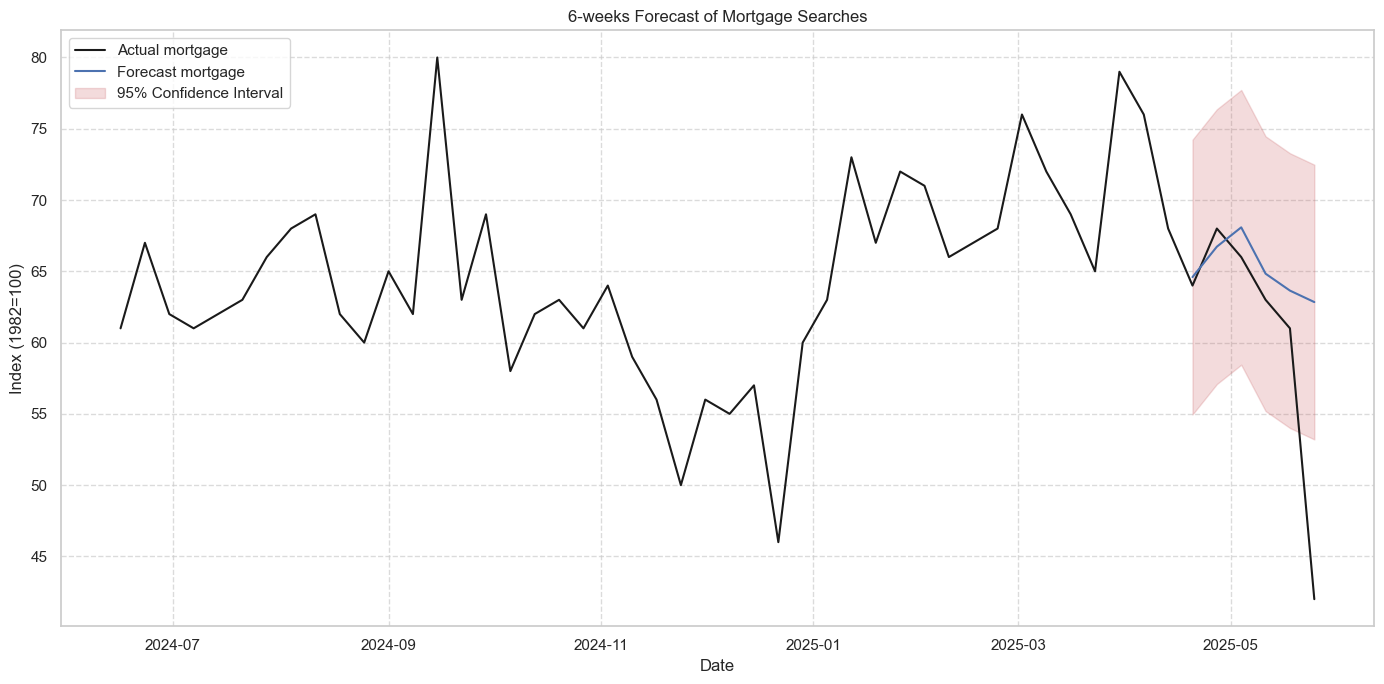

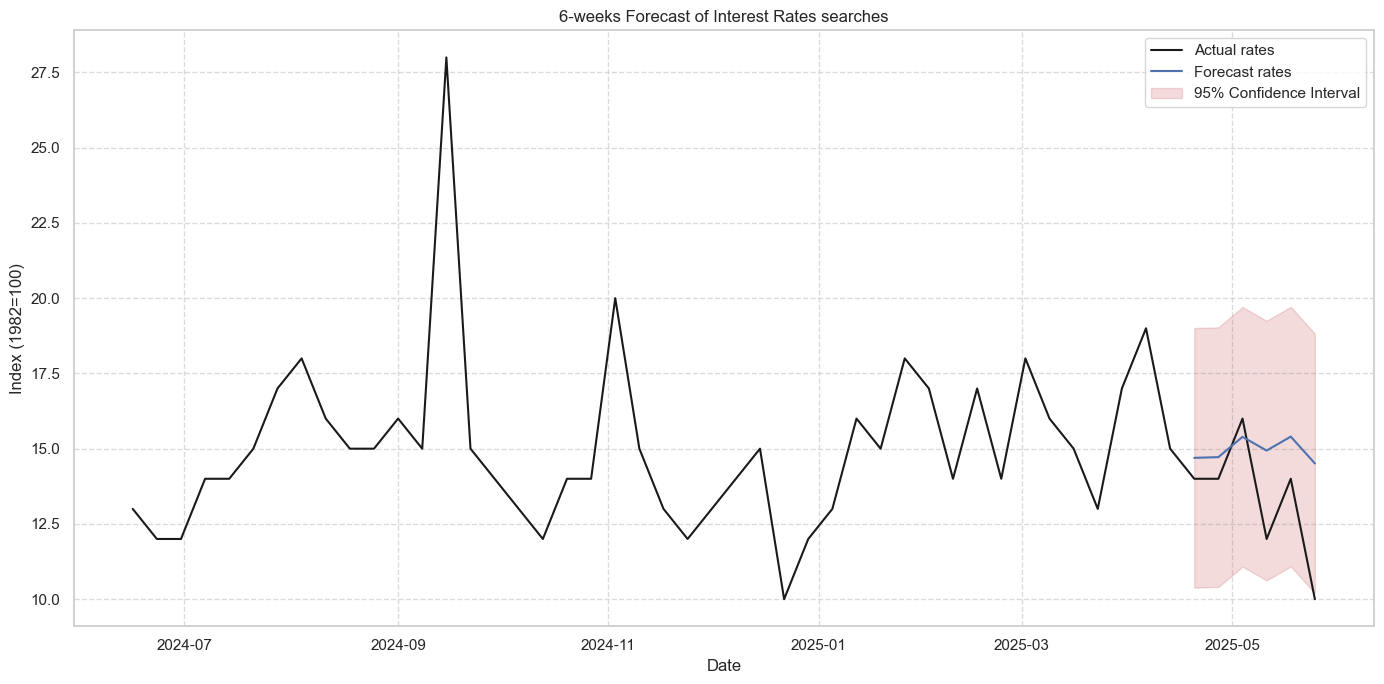

In [265]:
# Plot the mortgage forecasts vs actual values
plt.figure(figsize=(14, 7))

# Get the last 3 years of data for plotting context
plot_start_date = data_train.index[-14-36]  # 3 years before forecast start
plot_data = data_train.loc[plot_start_date:]

# Plot actual mortgage values (full history)
plt.plot(plot_data.index, plot_data['mortgage_world'], 'k-', label='Actual mortgage')

# Plot forecasted values
plt.plot(forecast_evaluation.index, forecast_evaluation['mortgage_forecast'], 'b-', label='Forecast mortgage')

# Plot confidence intervals
plt.fill_between(forecast_evaluation.index,
                forecast_evaluation['mortgage_lower'],
                forecast_evaluation['mortgage_upper'],
                color='r', alpha=0.2, label='95% Confidence Interval')

plt.title('6-weeks Forecast of Mortgage Searches')
plt.xlabel('Date')
plt.ylabel('Index (1982=100)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot the rates forecasts vs actual values
plt.figure(figsize=(14, 7))

# Plot actual rates values (full history)
plt.plot(plot_data.index, plot_data['rates_world'], 'k-', label='Actual rates')

# Plot forecasted values
plt.plot(forecast_evaluation.index, forecast_evaluation['rates_forecast'], 'b-', label='Forecast rates')

# Plot confidence intervals
plt.fill_between(forecast_evaluation.index,
                forecast_evaluation['rates_lower'],
                forecast_evaluation['rates_upper'],
                color='r', alpha=0.2, label='95% Confidence Interval')

plt.title('6-weeks Forecast of Interest Rates searches')
plt.xlabel('Date')
plt.ylabel('Index (1982=100)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [266]:
# Calculate forecast accuracy measures

# Define the function for MAPE and AMAPE
def mape(actual, pred):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((actual - pred) / actual)) * 100

def amape(actual, pred):
    """Adjusted/Symmetric Mean Absolute Percentage Error"""
    return np.mean(np.abs((actual - pred) / ((actual + pred) / 2))) * 100

# Calculate metrics for mortgage
mortgage_mae = mean_absolute_error(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])
mortgage_mse = mean_squared_error(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])
mortgage_rmse = np.sqrt(mortgage_mse)
mortgage_mape = mape(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])
mortgage_amape = amape(forecast_evaluation['mortgage_actual'], forecast_evaluation['mortgage_forecast'])

# Calculate metrics for rates
rates_mae = mean_absolute_error(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])
rates_mse = mean_squared_error(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])
rates_rmse = np.sqrt(rates_mse)
rates_mape = mape(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])
rates_amape = amape(forecast_evaluation['rates_actual'], forecast_evaluation['rates_forecast'])

# Create a DataFrame to display the results
metrics_df = pd.DataFrame({
    'mortgage': [mortgage_mae, mortgage_mse, mortgage_rmse, mortgage_mape, mortgage_amape],
    'rates': [rates_mae, rates_mse, rates_rmse, rates_mape, rates_amape]
}, index=['MAE', 'MSE', 'RMSE', 'MAPE (%)', 'AMAPE (%)'])

print("Forecast Accuracy Metrics:")
print(metrics_df)

Forecast Accuracy Metrics:
               mortgage         rates
MAE        4.8788437011  1.8113562016
MSE       75.1832432528  5.3818329885
RMSE       8.6708271378  2.3198777960
MAPE (%)  10.4718645379 15.5780397047
AMAPE (%)  8.7993422977 13.6417862839


## <a id="ARIMA-models"></a>ARIMA models - Box-Jenkins procedure

### <a id="ARIMA-model-identification"></a>ARIMA model identification

In [116]:
adf_test(data['mortgage_world'], max_aug=30)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-5.0798755533,-3.4340000000,-2.8630000000,-2.5680000000,9.0250000000,0.0027000000,28.6168000000,0.0000000000,40.2341000000,0.0000000000,54.3936000000,0.0000000000
1,1,-4.0621764783,-3.4340000000,-2.8630000000,-2.5680000000,0.8438000000,0.3583000000,20.8780000000,0.0009000000,31.0291000000,0.0006000000,46.4080000000,0.0000000000
2,2,-3.9262688208,-3.4340000000,-2.8630000000,-2.5680000000,6.4410000000,0.0112000000,19.0163000000,0.0019000000,31.0283000000,0.0006000000,46.8120000000,0.0000000000
3,3,-3.2052000726,-3.4340000000,-2.8630000000,-2.5680000000,1.3516000000,0.2450000000,11.4542000000,0.0431000000,26.0777000000,0.0036000000,34.4241000000,0.0030000000
4,4,-3.4185665204,-3.4340000000,-2.8630000000,-2.5680000000,9.1292000000,0.0025000000,18.0741000000,0.0029000000,24.5150000000,0.0063000000,36.0959000000,0.0017000000
5,5,-4.1412270465,-3.4340000000,-2.8630000000,-2.5680000000,1.3799000000,0.2401000000,7.4764000000,0.1876000000,12.8519000000,0.2321000000,26.2284000000,0.0357000000
6,6,-4.2444444814,-3.4340000000,-2.8630000000,-2.5680000000,0.0262000000,0.8715000000,4.9219000000,0.4255000000,21.4692000000,0.0180000000,22.8668000000,0.0870000000
7,7,-4.4151304844,-3.4340000000,-2.8630000000,-2.5680000000,0.2768000000,0.5988000000,7.4592000000,0.1887000000,19.8674000000,0.0305000000,20.5111000000,0.1532000000
8,8,-4.0974596273,-3.4340000000,-2.8630000000,-2.5680000000,3.0051000000,0.0830000000,8.6940000000,0.1219000000,18.0422000000,0.0543000000,19.1878000000,0.2053000000
9,9,-4.3593161273,-3.4340000000,-2.8630000000,-2.5680000000,0.5914000000,0.4419000000,10.4080000000,0.0645000000,14.8680000000,0.1369000000,19.4022000000,0.1961000000


In [117]:
adf_test(data['d_mortgage_world'], max_aug=30)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-20.5276751222,-3.4340000000,-2.8630000000,-2.5680000000,2.5222000000,0.1123000000,24.8187000000,0.0002000000,34.4372000000,0.0002000000,48.0486000000,0.0000000000
1,1,-13.7459853479,-3.4340000000,-2.8630000000,-2.5680000000,16.7534000000,0.0000000000,21.4158000000,0.0007000000,33.2925000000,0.0002000000,46.6335000000,0.0000000000
2,2,-13.7466705534,-3.4340000000,-2.8630000000,-2.5680000000,0.6518000000,0.4195000000,8.4096000000,0.1351000000,18.6327000000,0.0452000000,32.1436000000,0.0062000000
3,3,-9.6278187228,-3.4340000000,-2.8630000000,-2.5680000000,3.0328000000,0.0816000000,12.8111000000,0.0252000000,25.1910000000,0.0050000000,32.8279000000,0.0050000000
4,4,-7.5728512350,-3.4340000000,-2.8630000000,-2.5680000000,0.0558000000,0.8132000000,3.7315000000,0.5887000000,10.7083000000,0.3807000000,23.7591000000,0.0693000000
5,5,-7.8974732694,-3.4340000000,-2.8630000000,-2.5680000000,0.1852000000,0.6669000000,6.0794000000,0.2986000000,20.6266000000,0.0239000000,21.2692000000,0.1284000000
6,6,-6.6897197746,-3.4340000000,-2.8630000000,-2.5680000000,0.1750000000,0.6757000000,8.0687000000,0.1525000000,24.2040000000,0.0071000000,26.1715000000,0.0363000000
7,7,-6.3342574154,-3.4340000000,-2.8630000000,-2.5680000000,0.2172000000,0.6411000000,8.5080000000,0.1304000000,15.1805000000,0.1256000000,17.5675000000,0.2861000000
8,8,-5.4380967143,-3.4340000000,-2.8630000000,-2.5680000000,3.8686000000,0.0492000000,11.1979000000,0.0476000000,19.6028000000,0.0332000000,22.9923000000,0.0843000000
9,9,-5.7883936210,-3.4340000000,-2.8630000000,-2.5680000000,0.0723000000,0.7879000000,14.4917000000,0.0128000000,19.3083000000,0.0365000000,19.8046000000,0.1796000000


In [118]:
adf_test(data['rates_world'], max_aug=20)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.3648905215,-3.4340000000,-2.8630000000,-2.5680000000,17.5037000000,0.0000000000,59.7233000000,0.0000000000,68.4010000000,0.0000000000,79.3090000000,0.0000000000
1,1,-4.5193851780,-3.4340000000,-2.8630000000,-2.5680000000,7.0792000000,0.0078000000,50.1388000000,0.0000000000,55.0106000000,0.0000000000,67.1095000000,0.0000000000
2,2,-3.6677302587,-3.4340000000,-2.8630000000,-2.5680000000,12.7423000000,0.0004000000,44.5298000000,0.0000000000,49.4944000000,0.0000000000,61.8447000000,0.0000000000
3,3,-2.8718245249,-3.4340000000,-2.8630000000,-2.5680000000,10.6749000000,0.0011000000,34.5632000000,0.0000000000,40.5234000000,0.0000000000,50.9852000000,0.0000000000
4,4,-2.3178563107,-3.4340000000,-2.8630000000,-2.5680000000,22.7119000000,0.0000000000,27.4785000000,0.0000000000,39.0219000000,0.0000000000,44.0568000000,0.0001000000
5,5,-1.7027941042,-3.4340000000,-2.8630000000,-2.5680000000,0.3846000000,0.5352000000,5.6169000000,0.3453000000,21.1635000000,0.0200000000,26.0084000000,0.0379000000
6,6,-1.6233546529,-3.4340000000,-2.8630000000,-2.5680000000,2.0379000000,0.1534000000,5.2084000000,0.3910000000,20.5690000000,0.0243000000,26.4987000000,0.0331000000
7,7,-1.7485483338,-3.4340000000,-2.8630000000,-2.5680000000,0.5160000000,0.4726000000,13.9881000000,0.0157000000,20.0546000000,0.0287000000,31.1296000000,0.0084000000
8,8,-1.6610009609,-3.4340000000,-2.8630000000,-2.5680000000,2.4865000000,0.1148000000,13.6001000000,0.0184000000,20.0782000000,0.0285000000,37.9080000000,0.0009000000
9,9,-1.7977767124,-3.4340000000,-2.8630000000,-2.5680000000,0.2127000000,0.6447000000,16.1542000000,0.0064000000,20.2226000000,0.0272000000,37.5735000000,0.0010000000


In [119]:
adf_test(data['d_rates_world'], max_aug=20)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-23.3265777949,-3.4340000000,-2.8630000000,-2.5680000000,13.3437000000,0.0003000000,63.4038000000,0.0000000000,67.5941000000,0.0000000000,80.4902000000,0.0000000000
1,1,-16.5853368096,-3.4340000000,-2.8630000000,-2.5680000000,17.4084000000,0.0000000000,53.8753000000,0.0000000000,57.9831000000,0.0000000000,70.5249000000,0.0000000000
2,2,-14.9230703897,-3.4340000000,-2.8630000000,-2.5680000000,13.3623000000,0.0003000000,39.4801000000,0.0000000000,46.1325000000,0.0000000000,55.8988000000,0.0000000000
3,3,-13.6550088171,-3.4340000000,-2.8630000000,-2.5680000000,25.0435000000,0.0000000000,29.4408000000,0.0000000000,42.9816000000,0.0000000000,47.3853000000,0.0000000000
4,4,-14.2372929929,-3.4340000000,-2.8630000000,-2.5680000000,0.6192000000,0.4313000000,4.9727000000,0.4192000000,22.1225000000,0.0145000000,27.1896000000,0.0272000000
5,5,-11.0156675970,-3.4340000000,-2.8630000000,-2.5680000000,1.5150000000,0.2184000000,4.4724000000,0.4836000000,21.2745000000,0.0193000000,27.4682000000,0.0251000000
6,6,-8.1613803280,-3.4340000000,-2.8630000000,-2.5680000000,0.7897000000,0.3742000000,4.7994000000,0.4409000000,20.8012000000,0.0225000000,30.4185000000,0.0105000000
7,7,-7.5545162496,-3.4340000000,-2.8630000000,-2.5680000000,1.9115000000,0.1668000000,14.4223000000,0.0131000000,21.1052000000,0.0204000000,37.3507000000,0.0011000000
8,8,-6.1540201961,-3.4340000000,-2.8630000000,-2.5680000000,0.0740000000,0.7855000000,17.2567000000,0.0040000000,19.4049000000,0.0354000000,38.7745000000,0.0007000000
9,9,-5.5780268323,-3.4340000000,-2.8630000000,-2.5680000000,1.3525000000,0.2448000000,17.3666000000,0.0039000000,23.6205000000,0.0087000000,39.2532000000,0.0006000000


As per above, the difference in augmentations, which is needed to conclude that the differences of the series are stationary, equals to 1. Therefore, the series is integrated of order 1. So d = 1 for ARIMA (p,1,q).

Now let's determine r & q firstly for mortgages differences. Its ACF Plot above shows a significant spike at lag 1 and then appears to cut off immediately => might be MA(1), so q=1. PACF Plot shows a significant spike at lag 1 and then also appears to cut off => AR(1) & p=1. ARIMA (1,1,1)
As for interest rates differences, its ACF Plot shows a significant spike at lag 1. The spike at lag 2 is borderline => let's try MA(1). PACF Plot shows a significant spike at lag 1 and then also cuts off => AR(1). So final ARIMA (1,1,1)

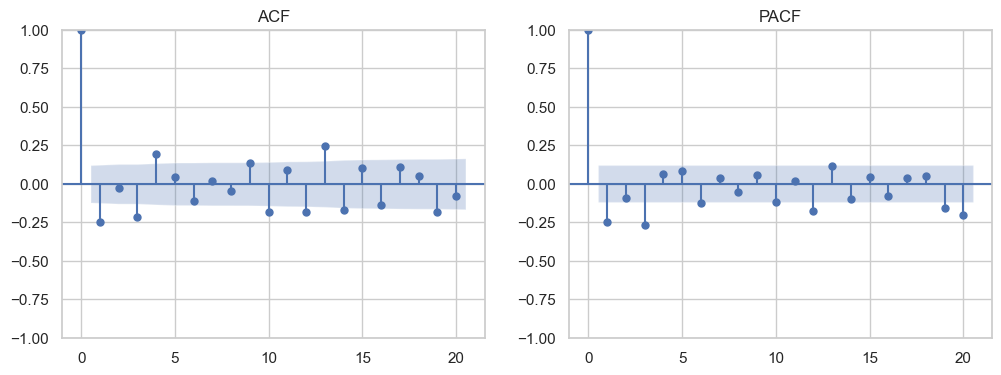

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(np.array(data['d_mortgage_world'])[1:], lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")

# Partial autocorrelation plot
plot_pacf(np.array(data['d_mortgage_world'])[1:], lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")

plt.show()

In [121]:

# Define and Fit the ARIMA model
arimaM111 = ARIMA(data_train['mortgage_world'].values, order=(1,1,1))
results_M111 = arimaM111.fit()

# Print the model summary
print("\n ARIMA Model Summary")
print(results_M111.summary())


 ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  262
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -811.169
Date:                Fri, 04 Jul 2025   AIC                           1628.339
Time:                        22:40:11   BIC                           1639.032
Sample:                             0   HQIC                          1632.637
                                - 262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3481      0.132      2.633      0.008       0.089       0.607
ma.L1         -0.6770      0.111     -6.113      0.000      -0.894      -0.460
sigma2        29.2884      1.9

Now let's test its residuals for autocorrelation.

In [122]:
ljung_test = acorr_ljungbox(results_M111.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

         lb_stat    lb_pvalue
5   6.3840669932 0.2706201045
10 10.7082268150 0.3806970247
15 17.2373371188 0.3048755149
20 26.6179546343 0.1463587297
25 32.7651116083 0.1370456156


The Ljung-Box test results suggest that the residuals of the ARIMA models are mostly uncorrelated, implying that the models have successfully captured the main structure of the data (since all lb_pvalues (0.27, 0.38, 0.30, 0.14, 0.13) are well above the common significance level of 0.05, we fail to reject the null hypothesis of no autocorrelation in the residuals)

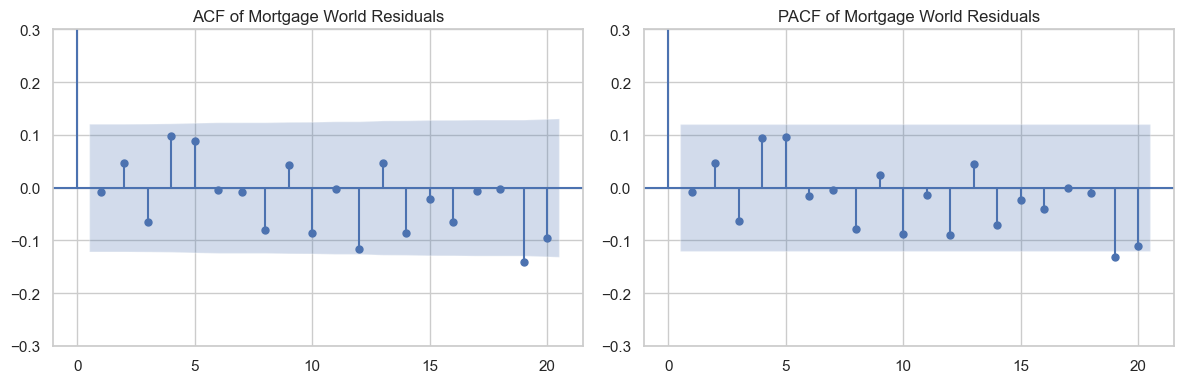

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot for MORTGAGE_WORLD residuals
# Use 'results.resid' to access the residuals of your fitted mortgage_world model
plot_acf(results_M111.resid, lags=20, ax=axes[0])
axes[0].set_title("ACF of Mortgage World Residuals")
axes[0].set_ylim([-0.3, 0.3]) # Limiting y-axis helps to see small deviations

# Partial autocorrelation plot for MORTGAGE_WORLD residuals
# Use 'results.resid' here too
plot_pacf(results_M111.resid, lags=20, ax=axes[1])
axes[1].set_title("PACF of Mortgage World Residuals")
axes[1].set_ylim([-0.3, 0.3]) # Limiting y-axis helps to see small deviations

plt.tight_layout() # Adjusts plot params for a tight layout
plt.show()

Almost all spikes are within the confidence bands without any pattern for a couple of out-of-bar spikes -> most probably, the residuals are white noise. Now the Interest Rates model.

Text(0.5, 1.0, 'PACF')

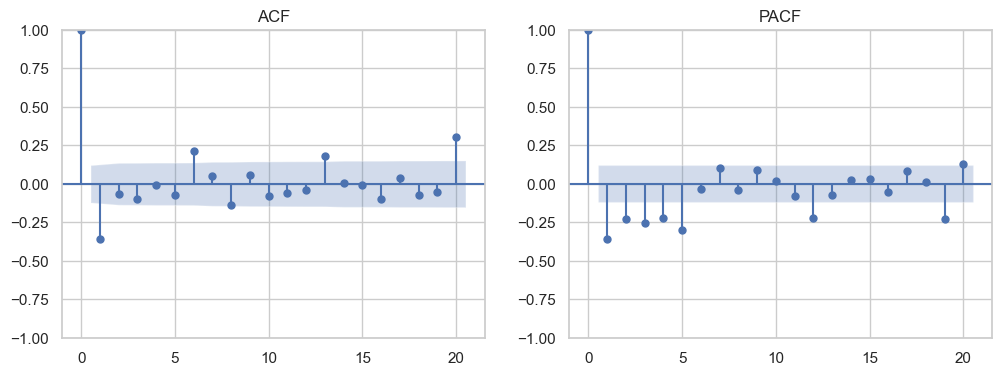

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(np.array(data['d_rates_world'])[1:], lags=20, ax=axes[0]) # ACF
axes[0].set_title("ACF")

# Partial autocorrelation plot
plot_pacf(np.array(data['d_rates_world'])[1:], lags=20, ax=axes[1]) # PACF
axes[1].set_title("PACF")

In [125]:
# Define and Fit the ARIMA model
arimaR111 = ARIMA(data_train['rates_world'].values, order=(1,1,1))
results_R111 = arimaR111.fit()

# Print the model summary
print("\n ARIMA Model Summary")
print(results_R111.summary())


 ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  262
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -591.097
Date:                Fri, 04 Jul 2025   AIC                           1188.194
Time:                        22:40:12   BIC                           1198.888
Sample:                             0   HQIC                          1192.492
                                - 262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2092      0.072      2.903      0.004       0.068       0.350
ma.L1         -0.8456      0.044    -19.222      0.000      -0.932      -0.759
sigma2         5.4092      0.2

In [126]:
ljung_test_rates = acorr_ljungbox(results_R111.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test_rates)

         lb_stat    lb_pvalue
5   2.8356412749 0.7253071779
10 24.3483781363 0.0067274804
15 35.7595332009 0.0019145718
20 61.1081239605 0.0000047918
25 63.7518232381 0.0000311869


There is significant autocorrelation in the residuals at longer lags -> model is underspecified. Let's try ARIMA(0,1,1), as ACF in the beginning cuts off at 1 and PACF tails off.


In [127]:
arimaR011 = ARIMA(data_train['rates_world'].values, order=(0,1,1))
results_R011 = arimaR011.fit()

# Print the model summary
print("\n ARIMA Model Summary")
print(results_R011.summary())


 ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  262
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -594.911
Date:                Fri, 04 Jul 2025   AIC                           1193.822
Time:                        22:40:12   BIC                           1200.951
Sample:                             0   HQIC                          1196.688
                                - 262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7703      0.041    -18.802      0.000      -0.851      -0.690
sigma2         5.5699      0.193     28.788      0.000       5.191       5.949
Ljung-Box (L1) (Q):           

In [128]:
ljung_test_rates = acorr_ljungbox(results_R011.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test_rates)

         lb_stat    lb_pvalue
5  13.5755589460 0.0185426213
10 41.1720741381 0.0000105195
15 56.6285575466 0.0000009487
20 85.5966390582 0.0000000004
25 88.3277433325 0.0000000054


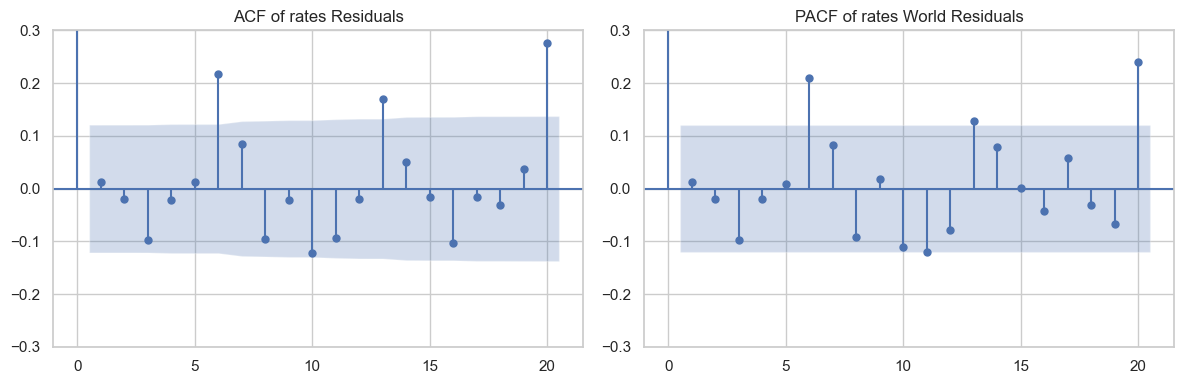

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot for MORTGAGE_WORLD residuals
# Use 'results.resid' to access the residuals of your fitted mortgage_world model
plot_acf(results_R111.resid, lags=20, ax=axes[0])
axes[0].set_title("ACF of rates Residuals")
axes[0].set_ylim([-0.3, 0.3]) # Limiting y-axis helps to see small deviations

# Partial autocorrelation plot for MORTGAGE_WORLD residuals
# Use 'results.resid' here too
plot_pacf(results_R111.resid, lags=20, ax=axes[1])
axes[1].set_title("PACF of rates World Residuals")
axes[1].set_ylim([-0.3, 0.3]) # Limiting y-axis helps to see small deviations

plt.tight_layout() # Adjusts plot params for a tight layout
plt.show()

ACF: Significant spikes outside the confidence bounds at 1,3,6,13 & PACF: 3,6,13. 1 & 2 have already been tried with unsuccessful outcome, therefore, AR (13) will be the starting point.

In [130]:
arimaR1311 = ARIMA(data_train['rates_world'].values, order=(6,1,1), enforce_stationarity=False, enforce_invertibility=False)
results_R1311 = arimaR1311.fit()

# Print the model summary
print("\n--- ARIMA Model Summary")
print(results_R1311.summary())


--- ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  262
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -569.954
Date:                Fri, 04 Jul 2025   AIC                           1155.908
Time:                        22:40:12   BIC                           1184.238
Sample:                             0   HQIC                          1167.304
                                - 262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3668      0.204     -6.705      0.000      -1.766      -0.967
ar.L2         -1.0204      0.138     -7.380      0.000      -1.291      -0.749
ar.L3         -0.9338      

In [131]:
ljung_test_rates = acorr_ljungbox(results_R1311.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test_rates)

         lb_stat    lb_pvalue
5   4.6768366643 0.4565773233
10  9.3370585034 0.5004420060
15 16.6484286587 0.3403119528
20 28.5444568838 0.0971243820
25 30.6221192395 0.2018378332


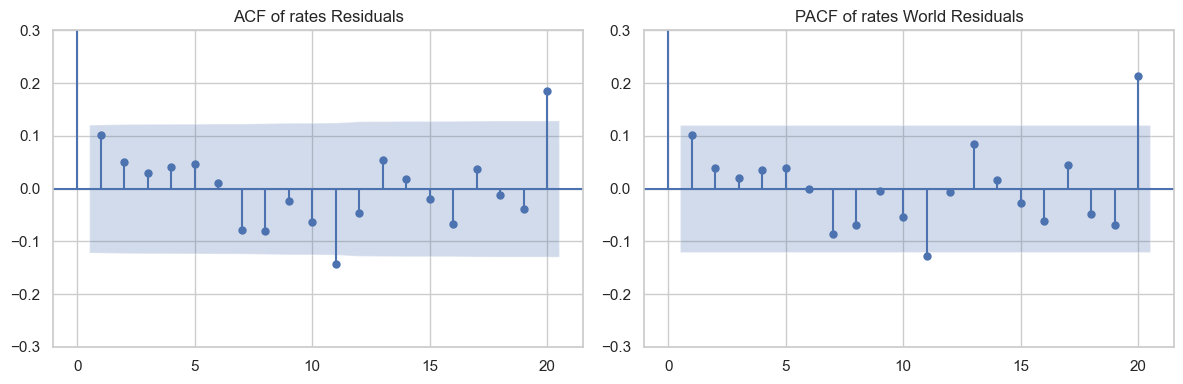

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot for MORTGAGE_WORLD residuals
# Use 'results.resid' to access the residuals of your fitted mortgage_world model
plot_acf(results_R1311.resid, lags=20, ax=axes[0])
axes[0].set_title("ACF of rates Residuals")
axes[0].set_ylim([-0.3, 0.3]) # Limiting y-axis helps to see small deviations

# Partial autocorrelation plot for MORTGAGE_WORLD residuals
# Use 'results.resid' here too
plot_pacf(results_R1311.resid, lags=20, ax=axes[1])
axes[1].set_title("PACF of rates World Residuals")
axes[1].set_ylim([-0.3, 0.3]) # Limiting y-axis helps to see small deviations

plt.tight_layout() # Adjusts plot params for a tight layout
plt.show()

This model is good for explaining the autocorrelation (white noise residuals), but its pretty complex (many insignificant model coefficients). Having tried out the model with AR (6) by ourselves, we concluded that we will proceed with the model presented above.

In [133]:
models = [results_R011, results_R111, results_R1311] # list with all the models
names = ['arimaR011', 'arimaR111', 'arimaR1311'] # models' names

# Preparing a DataFrame with models sorted by AIC, BIC
results = []
for model, name in zip(models, names):
    results.append([name, round(model.aic,2), round(model.bic,2)])
results_df = pd.DataFrame(results)
results_df.columns = ['model', 'AIC', 'BIC']

print('Models by AIC:\n',results_df.sort_values('AIC'))
print('Models by BIC:\n',results_df.sort_values('BIC'))

Models by AIC:
         model             AIC             BIC
2  arimaR1311 1155.9100000000 1184.2400000000
1   arimaR111 1188.1900000000 1198.8900000000
0   arimaR011 1193.8200000000 1200.9500000000
Models by BIC:
         model             AIC             BIC
2  arimaR1311 1155.9100000000 1184.2400000000
1   arimaR111 1188.1900000000 1198.8900000000
0   arimaR011 1193.8200000000 1200.9500000000


ARIMA(6,1,1) is the best performing model according to both AIC and BIC - lowest values.

### <a id="ARIMA-model-forecasting"></a>ARIMA model forecasting

In [134]:
arimaR1311 = ARIMA(data_train_short['rates_world'].values, order=(6,1,1), enforce_stationarity=False, enforce_invertibility=False)
results_R1311 = arimaR1311.fit()

# Print the model summary
print("\n--- ARIMA Model Summary")
print(results_R1311.summary())


--- ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  256
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -555.461
Date:                Fri, 04 Jul 2025   AIC                           1126.922
Time:                        22:40:13   BIC                           1155.062
Sample:                             0   HQIC                          1138.249
                                - 256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3362      0.248     -5.399      0.000      -1.821      -0.851
ar.L2         -1.0122      0.161     -6.279      0.000      -1.328      -0.696
ar.L3         -0.9242      

In [135]:
data_test = data_train.tail(6)

In [136]:
data_test

,mortgage_world,rates_world
Date,,
2025-04-20,64,14
2025-04-27,68,14
2025-05-04,66,16
2025-05-11,63,12
2025-05-18,61,14
2025-05-25,42,10


In [137]:

# Forecast for next ten observations (2 working weeks)
forecast_results = results_R1311.get_forecast(steps=6)

# Point forecast
forecast_values = forecast_results.predicted_mean

# Confidence (by default 95%) intervals of the point forecast
confidence_intervals = forecast_results.conf_int()

forecast_df = pd.DataFrame({
    "forecast": forecast_values,
    "lower_CI": confidence_intervals[:, 0],
    "upper_CI": confidence_intervals[:, 1],
    "rates_world": data_test['rates_world']
}, index=data_test.index)

forecast_df

,forecast,lower_CI,upper_CI,rates_world
Date,,,,
2025-04-20,16.0119686454,11.6036859809,20.4202513099,14
2025-04-27,15.2479998434,10.5874553831,19.9085443036,14
2025-05-04,15.2622331906,10.5118101483,20.0126562330,16
2025-05-11,15.7724291186,10.9880328786,20.5568253586,12
2025-05-18,17.0118052866,12.1722003881,21.8514101852,14
2025-05-25,16.0011309062,11.0901657533,20.9120960591,10


In [138]:
final_df = pd.concat([data_train_short['rates_world'], forecast_df], axis=0)

final_df

,rates_world,forecast,lower_CI,upper_CI
Date,,,,
2020-05-24,11,NaN,NaN,NaN
2020-05-31,12,NaN,NaN,NaN
2020-06-07,12,NaN,NaN,NaN
2020-06-14,11,NaN,NaN,NaN
2020-06-21,11,NaN,NaN,NaN
...,...,...,...,...
2025-04-27,14,15.2479998434,10.5874553831,19.9085443036
2025-05-04,16,15.2622331906,10.5118101483,20.0126562330
2025-05-11,12,15.7724291186,10.9880328786,20.5568253586


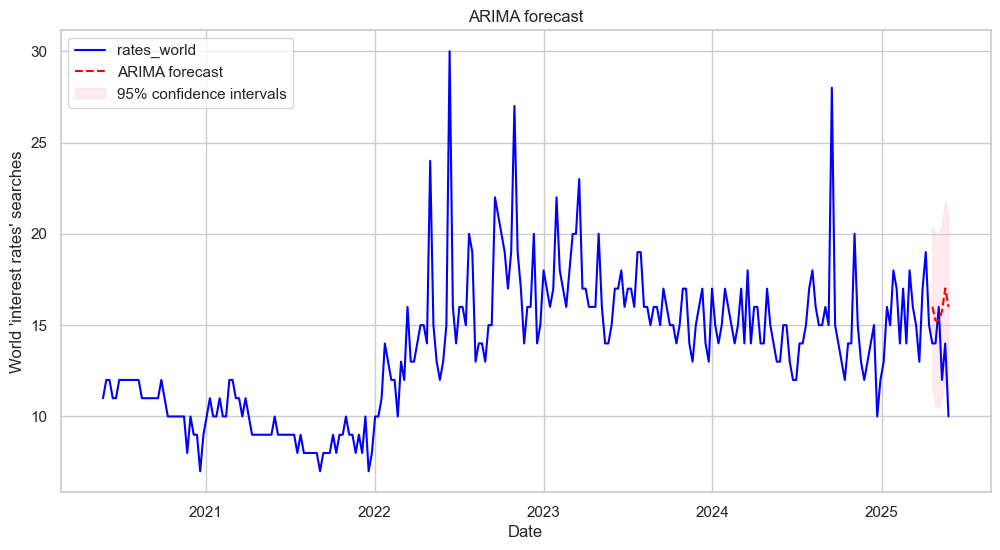

In [139]:
plt.figure(figsize=(12, 6))

# Plotting the true values (in-sample, out-of-sample)
plt.plot(final_df.index,
         final_df["rates_world"],
         label="rates_world",
         color="blue",
         linestyle="-")

# Plotting the forecast
plt.plot(final_df.index,
         final_df["forecast"],
         label="ARIMA forecast",
         color="red",
         linestyle="dashed")

# Plotting the confidence intervals
plt.fill_between(final_df.index,
                 final_df["lower_CI"],
                 final_df["upper_CI"],
                 color='pink',
                 alpha=0.3,
                 label="95% confidence intervals")

plt.title("ARIMA forecast")
plt.xlabel("Date")
plt.ylabel("World 'interest rates' searches")
plt.legend()
plt.grid(True)

plt.show()

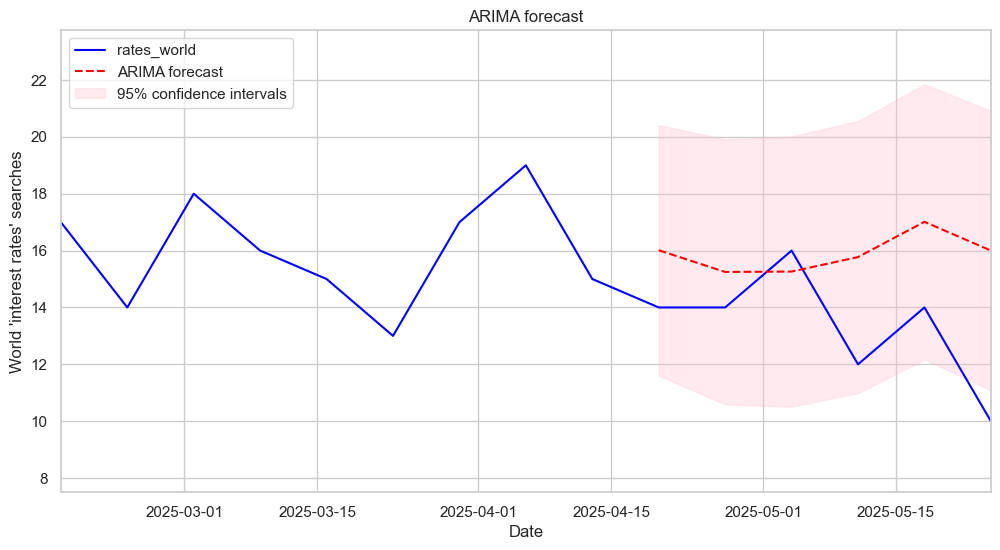

In [140]:
plt.figure(figsize=(12, 6))

# Plotting the true values (in-sample, out-of-sample)
plt.plot(final_df.index,
         final_df["rates_world"],
         label="rates_world",
         color="blue",
         linestyle="-")

# Plotting the forecast
plt.plot(final_df.index,
         final_df["forecast"],
         label="ARIMA forecast",
         color="red",
         linestyle="dashed")

# Plotting the confidence intervals
plt.fill_between(final_df.index,
                 final_df["lower_CI"],
                 final_df["upper_CI"],
                 color='pink',
                 alpha=0.3,
                 label="95% confidence intervals")

plt.title("ARIMA forecast")
plt.xlabel("Date")
plt.ylabel("World 'interest rates' searches")
plt.legend()
plt.grid(True)

# Here, we zoom the plot by putting limits on X and Y axes values
plt.xlim(final_df.index[-15], final_df.index[-1])
plt.ylim(final_df.tail(15)["rates_world"].min() * 0.75, final_df.tail(15)["rates_world"].max() * 1.25)


plt.show()

In [141]:
true_values = forecast_df["rates_world"].values
forecast_values = forecast_df["forecast"].values
n = len(forecast_values)

# 1. MAE (Mean Absolute Error)
mae = np.sum(np.abs(true_values - forecast_values)) / n

# 2. RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.sum((true_values - forecast_values) ** 2) / n)

# 3. MAPE (Mean Absolute Percentage Error)
mape = np.sum(np.abs((true_values - forecast_values) / true_values)) / n * 100

# 4. AMAPE (Adjusted Mean Absolute Percentage Error)
epsilon = 1e-8  # Small value to avoid division by zero
amape = np.sum(np.abs((true_values - forecast_values) / (np.abs(true_values) + epsilon))) / n * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"AMAPE: {amape:.2f}%")


MAE: 2.80
RMSE: 3.30
MAPE: 23.48%
AMAPE: 23.48%


Mortgage

In [142]:
arimaM111 = ARIMA(data_train_short['mortgage_world'].values, order=(1,1,1))
results_M111 = arimaM111.fit()

# Print the model summary
print("\n ARIMA Model Summary")
print(results_M111.summary())


 ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  256
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -786.801
Date:                Fri, 04 Jul 2025   AIC                           1579.602
Time:                        22:40:14   BIC                           1590.226
Sample:                             0   HQIC                          1583.875
                                - 256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3611      0.116      3.101      0.002       0.133       0.589
ma.L1         -0.7059      0.095     -7.450      0.000      -0.892      -0.520
sigma2        27.9988      2.0

In [143]:
forecast_results = results_M111.get_forecast(steps=6)

# Point forecast
forecast_values = forecast_results.predicted_mean

# Confidence (by default 95%) intervals of the point forecast
confidence_intervals = forecast_results.conf_int()

forecast_df = pd.DataFrame({
    "forecast": forecast_values,
    "lower_CI": confidence_intervals[:, 0],
    "upper_CI": confidence_intervals[:, 1],
    "mortgage_world": data_test['mortgage_world']
}, index=data_test.index)

forecast_df

,forecast,lower_CI,upper_CI,mortgage_world
Date,,,,
2025-04-20,69.6970411206,59.3261069438,80.0679752974,64
2025-04-27,70.3097669880,57.9114294888,82.7081044872,68
2025-05-04,70.5309949736,56.9662955568,84.0956943904,66
2025-05-11,70.6108705333,56.1412737308,85.0804673358,63
2025-05-18,70.6397100358,55.3730814673,85.9063386043,61
2025-05-25,70.6501226940,54.6444190077,86.6558263803,42


In [144]:
final_df = pd.concat([data_train_short['mortgage_world'], forecast_df], axis=0)

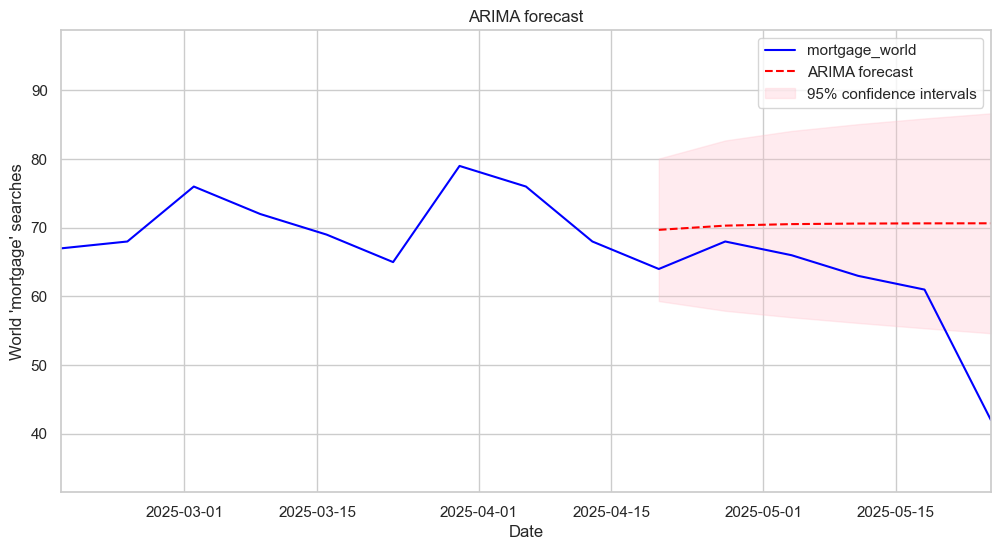

In [145]:
plt.figure(figsize=(12, 6))

# Plotting the true values (in-sample, out-of-sample)
plt.plot(final_df.index,
         final_df["mortgage_world"],
         label="mortgage_world",
         color="blue",
         linestyle="-")

# Plotting the forecast
plt.plot(final_df.index,
         final_df["forecast"],
         label="ARIMA forecast",
         color="red",
         linestyle="dashed")

# Plotting the confidence intervals
plt.fill_between(final_df.index,
                 final_df["lower_CI"],
                 final_df["upper_CI"],
                 color='pink',
                 alpha=0.3,
                 label="95% confidence intervals")

plt.title("ARIMA forecast")
plt.xlabel("Date")
plt.ylabel("World 'mortgage' searches")
plt.legend()
plt.grid(True)

# Here, we zoom the plot by putting limits on X and Y axes values
plt.xlim(final_df.index[-15], final_df.index[-1])
plt.ylim(final_df.tail(15)["mortgage_world"].min() * 0.75, final_df.tail(15)["mortgage_world"].max() * 1.25)


plt.show()

The ARIMA forecast for rates tends to slightly underpredict in the final two weeks, suggesting it may not capture short-term volatility as effectively as VAR.

In [146]:
true_values = forecast_df["mortgage_world"].values
forecast_values = forecast_df["forecast"].values
n = len(forecast_values)

# 1. MAE (Mean Absolute Error)
mae = np.sum(np.abs(true_values - forecast_values)) / n

# 2. RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.sum((true_values - forecast_values) ** 2) / n)

# 3. MAPE (Mean Absolute Percentage Error)
mape = np.sum(np.abs((true_values - forecast_values) / true_values)) / n * 100

# 4. AMAPE (Adjusted Mean Absolute Percentage Error)
epsilon = 1e-8  # Small value to avoid division by zero
amape = np.sum(np.abs((true_values - forecast_values) / (np.abs(true_values) + epsilon))) / n * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"AMAPE: {amape:.2f}%")

MAE: 9.74
RMSE: 13.10
MAPE: 19.21%
AMAPE: 19.21%


## <a id="Model-Comparison"></a>Model Comparison

### <a id="Morgage-Rates"></a>Mortgage Rates - VAR (6) & ARIMA (1,1,1)

In [147]:
def generate_markdown_table(headers, data, align='left'):
    """
    Generates a Markdown table string.

    Args:
        headers (list): A list of strings for the table headers.
        data (list of lists): A list of lists, where each inner list represents a row of data.
        align (str or list): 'left', 'center', 'right' for all columns, or a list of
                              'left', 'center', 'right' for each column.

    Returns:
        str: The Markdown table string.
    """
    if not headers:
        return ""
    if not data:
        # Just headers if no data
        header_line = "| " + " | ".join(headers) + " |"
        separator_line = "|---" * len(headers) + "|"
        return f"{header_line}\n{separator_line}"

    # Determine column widths for consistent formatting (optional but good for readability)
    col_widths = [len(header) for header in headers]
    for row in data:
        for i, cell in enumerate(row):
            col_widths[i] = max(col_widths[i], len(str(cell)))

    # Handle alignment
    if isinstance(align, str):
        align_list = [align] * len(headers)
    elif isinstance(align, list) and len(align) == len(headers):
        align_list = align
    else:
        raise ValueError("Align must be 'left', 'center', 'right' or a list of these for each column.")

    # Build the header line
    header_parts = []
    for i, header in enumerate(headers):
        header_parts.append(f"{header:<{col_widths[i]}}") # Left-align header for now
    header_line = "| " + " | ".join(header_parts) + " |"

    # Build the separator line
    separator_parts = []
    for i, width in enumerate(col_widths):
        if align_list[i] == 'left':
            separator_parts.append(f":{'-' * (width - 1)}")
        elif align_list[i] == 'center':
            separator_parts.append(f":{'-' * (width - 2)}:")
        elif align_list[i] == 'right':
            separator_parts.append(f"{'-' * (width - 1)}:")
        else:
            separator_parts.append("-" * width) # Default to left if invalid align
    separator_line = "| " + " | ".join(separator_parts) + " |"

    # Build the data rows
    data_lines = []
    for row in data:
        row_parts = []
        for i, cell in enumerate(row):
            if align_list[i] == 'left':
                row_parts.append(f"{str(cell):<{col_widths[i]}}")
            elif align_list[i] == 'center':
                row_parts.append(f"{str(cell):^{col_widths[i]}}")
            elif align_list[i] == 'right':
                row_parts.append(f"{str(cell):>{col_widths[i]}}")
            else:
                row_parts.append(f"{str(cell):<{col_widths[i]}}") # Default to left
        data_lines.append("| " + " | ".join(row_parts) + " |")

    # Combine all parts
    return f"{header_line}\n{separator_line}\n" + "\n".join(data_lines)


# Data for the "x-Post Forecast Error Comparison – Mortgage" table
headers = ["Metric", "ARIMA", "VAR(6)", "Better Model"]
data = [
    ["MAE", "9.74", "4.88", "✅ VAR"],
    ["RMSE", "13.10", "8.67", "✅ VAR"],
    ["MAPE (%)", "19.21%", "10.47%", "✅ VAR"],
    ["AMAPE (%)", "19.21%", "8.80%", "✅ VAR"]
]

# Define alignment for each column:
# Metric: left
# ARIMA: right (for numbers)
# VAR(6): right (for numbers)
# Better Model: center
alignments = ['left', 'right', 'right', 'center']

# Generate the Markdown table
markdown_table = generate_markdown_table(headers, data, align=alignments)

print("### x-Post Forecast Error Comparison – Mortgage")
print(markdown_table)

### x-Post Forecast Error Comparison – Mortgage
| Metric    | ARIMA  | VAR(6) | Better Model |
| :-------- | -----: | -----: | :----------: |
| MAE       |   9.74 |   4.88 |    ✅ VAR     |
| RMSE      |  13.10 |   8.67 |    ✅ VAR     |
| MAPE (%)  | 19.21% | 10.47% |    ✅ VAR     |
| AMAPE (%) | 19.21% |  8.80% |    ✅ VAR     |


For the mortgage_world series, the VAR(6) model provides significantly more accurate forecasts than the ARIMA model, as shown by lower MAE, RMSE, MAPE, and AMAPE values.

### <a id="Interest-Rates"></a>Interest Rates - VAR (6) & ARIMA (13,1,1)

In [148]:
def generate_markdown_table(headers, data, align='left'):
    """
    Generates a Markdown table string.

    Args:
        headers (list): A list of strings for the table headers.
        data (list of lists): A list of lists, where each inner list represents a row of data.
        align (str or list): 'left', 'center', 'right' for all columns, or a list of
                              'left', 'center', 'right' for each column.

    Returns:
        str: The Markdown table string.
    """
    if not headers:
        return ""
    if not data:
        # Just headers if no data
        header_line = "| " + " | ".join(headers) + " |"
        separator_line = "|---" * len(headers) + "|"
        return f"{header_line}\n{separator_line}"

    # Determine column widths for consistent formatting (optional but good for readability)
    col_widths = [len(header) for header in headers]
    for row in data:
        for i, cell in enumerate(row):
            col_widths[i] = max(col_widths[i], len(str(cell)))

    # Handle alignment
    if isinstance(align, str):
        align_list = [align] * len(headers)
    elif isinstance(align, list) and len(align) == len(headers):
        align_list = align
    else:
        raise ValueError("Align must be 'left', 'center', 'right' or a list of these for each column.")

    # Build the header line
    header_parts = []
    for i, header in enumerate(headers):
        header_parts.append(f"{header:<{col_widths[i]}}") # Left-align header for now
    header_line = "| " + " | ".join(header_parts) + " |"

    # Build the separator line
    separator_parts = []
    for i, width in enumerate(col_widths):
        if align_list[i] == 'left':
            separator_parts.append(f":{'-' * (width - 1)}")
        elif align_list[i] == 'center':
            separator_parts.append(f":{'-' * (width - 2)}:")
        elif align_list[i] == 'right':
            separator_parts.append(f"{'-' * (width - 1)}:")
        else:
            separator_parts.append("-" * width) # Default to left if invalid align
    separator_line = "| " + " | ".join(separator_parts) + " |"

    # Build the data rows
    data_lines = []
    for row in data:
        row_parts = []
        for i, cell in enumerate(row):
            if align_list[i] == 'left':
                row_parts.append(f"{str(cell):<{col_widths[i]}}")
            elif align_list[i] == 'center':
                row_parts.append(f"{str(cell):^{col_widths[i]}}")
            elif align_list[i] == 'right':
                row_parts.append(f"{str(cell):>{col_widths[i]}}")
            else:
                row_parts.append(f"{str(cell):<{col_widths[i]}}") # Default to left
        data_lines.append("| " + " | ".join(row_parts) + " |")

    # Combine all parts
    return f"{header_line}\n{separator_line}\n" + "\n".join(data_lines)


# Data for the "Ex-Post Forecast Error Comparison – Interest Rates" table
headers = ["Metric", "ARIMA", "VAR(6)", "Better Model"]
data = [
    ["MAE", "2.80", "4.88", "✅ ARIMA"],
    ["RMSE", "3.30", "2.32", "✅ VAR"],
    ["MAPE (%)", "23.48%", "15.58%", "✅ VAR"],
    ["AMAPE (%)", "23.48%", "13.64%", "✅ VAR"]
]

# Define alignment for each column:
# Metric: left
# ARIMA: right (for numbers)
# VAR(6): right (for numbers)
# Better Model: center
alignments = ['left', 'right', 'right', 'center']

# Generate the Markdown table
markdown_table = generate_markdown_table(headers, data, align=alignments)

# Print the table with a title
print("### Ex-Post Forecast Error Comparison – Interest Rates")
print(markdown_table)

### Ex-Post Forecast Error Comparison – Interest Rates
| Metric    | ARIMA  | VAR(6) | Better Model |
| :-------- | -----: | -----: | :----------: |
| MAE       |   2.80 |   4.88 |   ✅ ARIMA    |
| RMSE      |   3.30 |   2.32 |    ✅ VAR     |
| MAPE (%)  | 23.48% | 15.58% |    ✅ VAR     |
| AMAPE (%) | 23.48% | 13.64% |    ✅ VAR     |


For the rates_world series, the VAR(6) model achieves lower RMSE, MAPE, and AMAPE, showing better overall forecast performance for variability and percentage error. Although ARIMA has a lower MAE, the VAR model is clearly more accurate.

### <a id="Final-Results"></a>Conclusion

Overall, the VAR model in our case performs more reliably across both time series. While ARIMA provides acceptable results, its higher error metrics and signs of autocorrelation in residuals make it less suitable for short-term forecasting.